# Dataset loading

We're going to use the roboflow dataset: ***6 Sided Dice Dataset***

https://public.roboflow.com/object-detection/dice

You may consider a few options how to get the data to have an experiment with:

* Download it manually from the link
* Use the roboflow API to download the dataset

In [ ]:
# Download the data

!curl -L "https://public.roboflow.com/ds/hGd8PtDQQe?key=ldH4CP0l3V" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   2529      0 --:--:-- --:--:-- --:--:--  2529
100 51.4M  100 51.4M    0     0  37.3M      0  0:00:01  0:00:01 --:--:--  372M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: export/
   creating: export/images/
 extracting: export/images/0BrzNN9qMnzQlQPZ1sso.jpg  
 extracting: export/images/0kpaB4UeoohBVODkOmGd.jpg  
 extracting: export/images/0thII0LnXrzeDTZ6HbiS.jpg  
 extracting: export/images/1W3kCdCcSnq0jkQiZZ00.jpg  
 extracting: export/images/1XPc36ZuLHMLotkAKZfP.jpg  
 extracting: export/images/1YO2nsEEBcYqrlqAjWnN.jpg  
 extracting: export/images/1bq71k3UzSwfjl92NWoE.jpg  
 extracting: export/images/1dRQgfot47CoYg4LXtcM.jpg  
 extracting: export/images/1dtjooCYlexEbdq5MFnj.jpg  
 extracting:

In this dataset, someone has captured and annotated photos of six-sided dice. There are 359 total images from a few sets:

* 154 single dice of various styles on a white table
* 388 Catan Dice (Red and Yellow, some rolled on a white table, 160 on top of or near the Catan board)
* 13 mass groupings of dice in various styles

# Necessary imports and constants

In [ ]:
import pathlib
import os
import random
import shutil

IMAGE_PATH = pathlib.Path('/content/export/images')
print(f'We have {len(list(IMAGE_PATH.glob("*.jpg")))} samples')
LABEL_PATH = pathlib.Path('/content/export/labels')
print(f'We have {len(list(LABEL_PATH.glob("*.txt")))} annotations')

We have 718 samples
We have 718 annotations


It looks like the description of the dataset doesn't really match it's specification...

In [ ]:
# Define the dirs for the data we have
train_path = pathlib.Path('/content/train')
test_path = pathlib.Path('/content/valid')


os.mkdir(train_path)
os.mkdir(test_path)
os.mkdir(train_path / 'labels')
os.mkdir(train_path / 'images')
os.mkdir(test_path / 'images')
os.mkdir(test_path / 'labels')

# Random_sample_shuffling

Because in the current dataset data is not separated onto the train/test/valid sets we're doing that ourselves. Here the random sample split is implemented

In [ ]:
def get_random_test_val_split(
    img_path: pathlib.PosixPath,
    label_path: pathlib.PosixPath,
    percantage_train:float = 0.8
):

    image_dir = img_path
    label_dir = label_path

    num_train_samples = round(len(list(image_dir.glob('*.jpg')))*percantage_train)

    train_img_paths = random.sample(list(image_dir.glob('*.jpg')), k=num_train_samples)
    train_label_paths = [pathlib.Path(label_dir) / (path.stem + '.txt') for path in train_img_paths]

    for img, label in zip(train_img_paths, train_label_paths):

        new_img_path = train_path / 'images' / img.name
        new_label_path = train_path / 'labels' / label.name
        shutil.move(img, new_img_path)
        shutil.move(label, new_label_path)

    valid_img_path = list(image_dir.glob('*.jpg'))
    valid_label_path = [pathlib.Path(label_dir) / (path.stem + '.txt') for path in valid_img_path]

    for img, label in zip(valid_img_path, valid_label_path):

        new_img_path = test_path / 'images' / img.name
        new_label_path = test_path / 'labels' / label.name
        shutil.move(img, new_img_path)
        shutil.move(label, new_label_path)

    print(f'Transfered succesfully!')
    print(f'Len of the train data is {len(train_img_paths)}')
    print(f'Len of the validation data is {len(valid_img_path)}')

In [ ]:
get_random_test_val_split(
    img_path=IMAGE_PATH,
    label_path=LABEL_PATH,
)

Transfered succesfully!
Len of the train data is 574
Len of the validation data is 144


# YOLO V5 Training attempt

YOLO (You Only Look Once)  - it's the SOTA model architecture for the fast model detection. YOLO's significant advantage lies in its real-time performance, as it processes the entire image in a single forward pass through the network. This avoids the need for region proposal operations or multiple stages, making YOLO incredibly fast.

You may find dall the necessary additional information on the link: https://arxiv.org/pdf/1506.02640v5.pdf

We're going to use two variations: YoloV5 and ToloV8 in this notebook for the comparison of the performance.

## Downloading and defining the model

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 15957, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 15957 (delta 39), reused 52 (delta 28), pack-reused 15880
Receiving objects: 100% (15957/15957), 14.69 MiB | 19.09 MiB/s, done.
Resolving deltas: 100% (10938/10938), done.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


yaml file contains the information about numbers of classes and the location of the image and label files in the workspace.

In [ ]:
%cat /content/data.yaml

train: ../train/images
val: ../valid/images

nc: 6
names: ['1', '2', '3', '4', '5', '6']

In [ ]:
import yaml
with open("/content/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
num_classes

'6'

Model's yaml file contains the settings and hyperparameters that may be modified. Pretrained architecture's number of classes differ from what we want, so, we'll modify that file.

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
#Check whether the file has been created or not
%cat /content/yolov5/models/custom_yolov5s.yaml


# parameters
nc: 6  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

In [ ]:
# To avoid any import missings

%pip install -r /content/yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00


In [ ]:
# train yolov5s for 300 epochs using train.py file
# imgzise 640, batch_size 32
%%time
%cd /content/yolov5/
%python train.py --img 640 --batch 32 --epochs 300 --data /content/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2023-09-10 06:27:14.748351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 06:27:15.628088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1,

## Training results visualization

To evaluate object detection results bunch of metrics are used:

* **Precision** and **Recall** are equivalent to those in the multiclass classification
* **mAP** stands for **Mean Average Precision(mAP)** is a metric used to evaluate object detection models. It is calculating as follows:

$$ mAP = \frac{1}{N} \sum_{i=1}^{N}AP_i $$

Notations after the mAP such as mAP*50* or mAP*50-95* means average mAP over different IoU thresholds

* **IoU** -  a metric used to evaluate Deep Learning algorithms by estimating how well a predicted mask or bounding box matches the ground truth data.

$$IoU = \frac{Area Of Overlap}{AreaOfUnion}$$

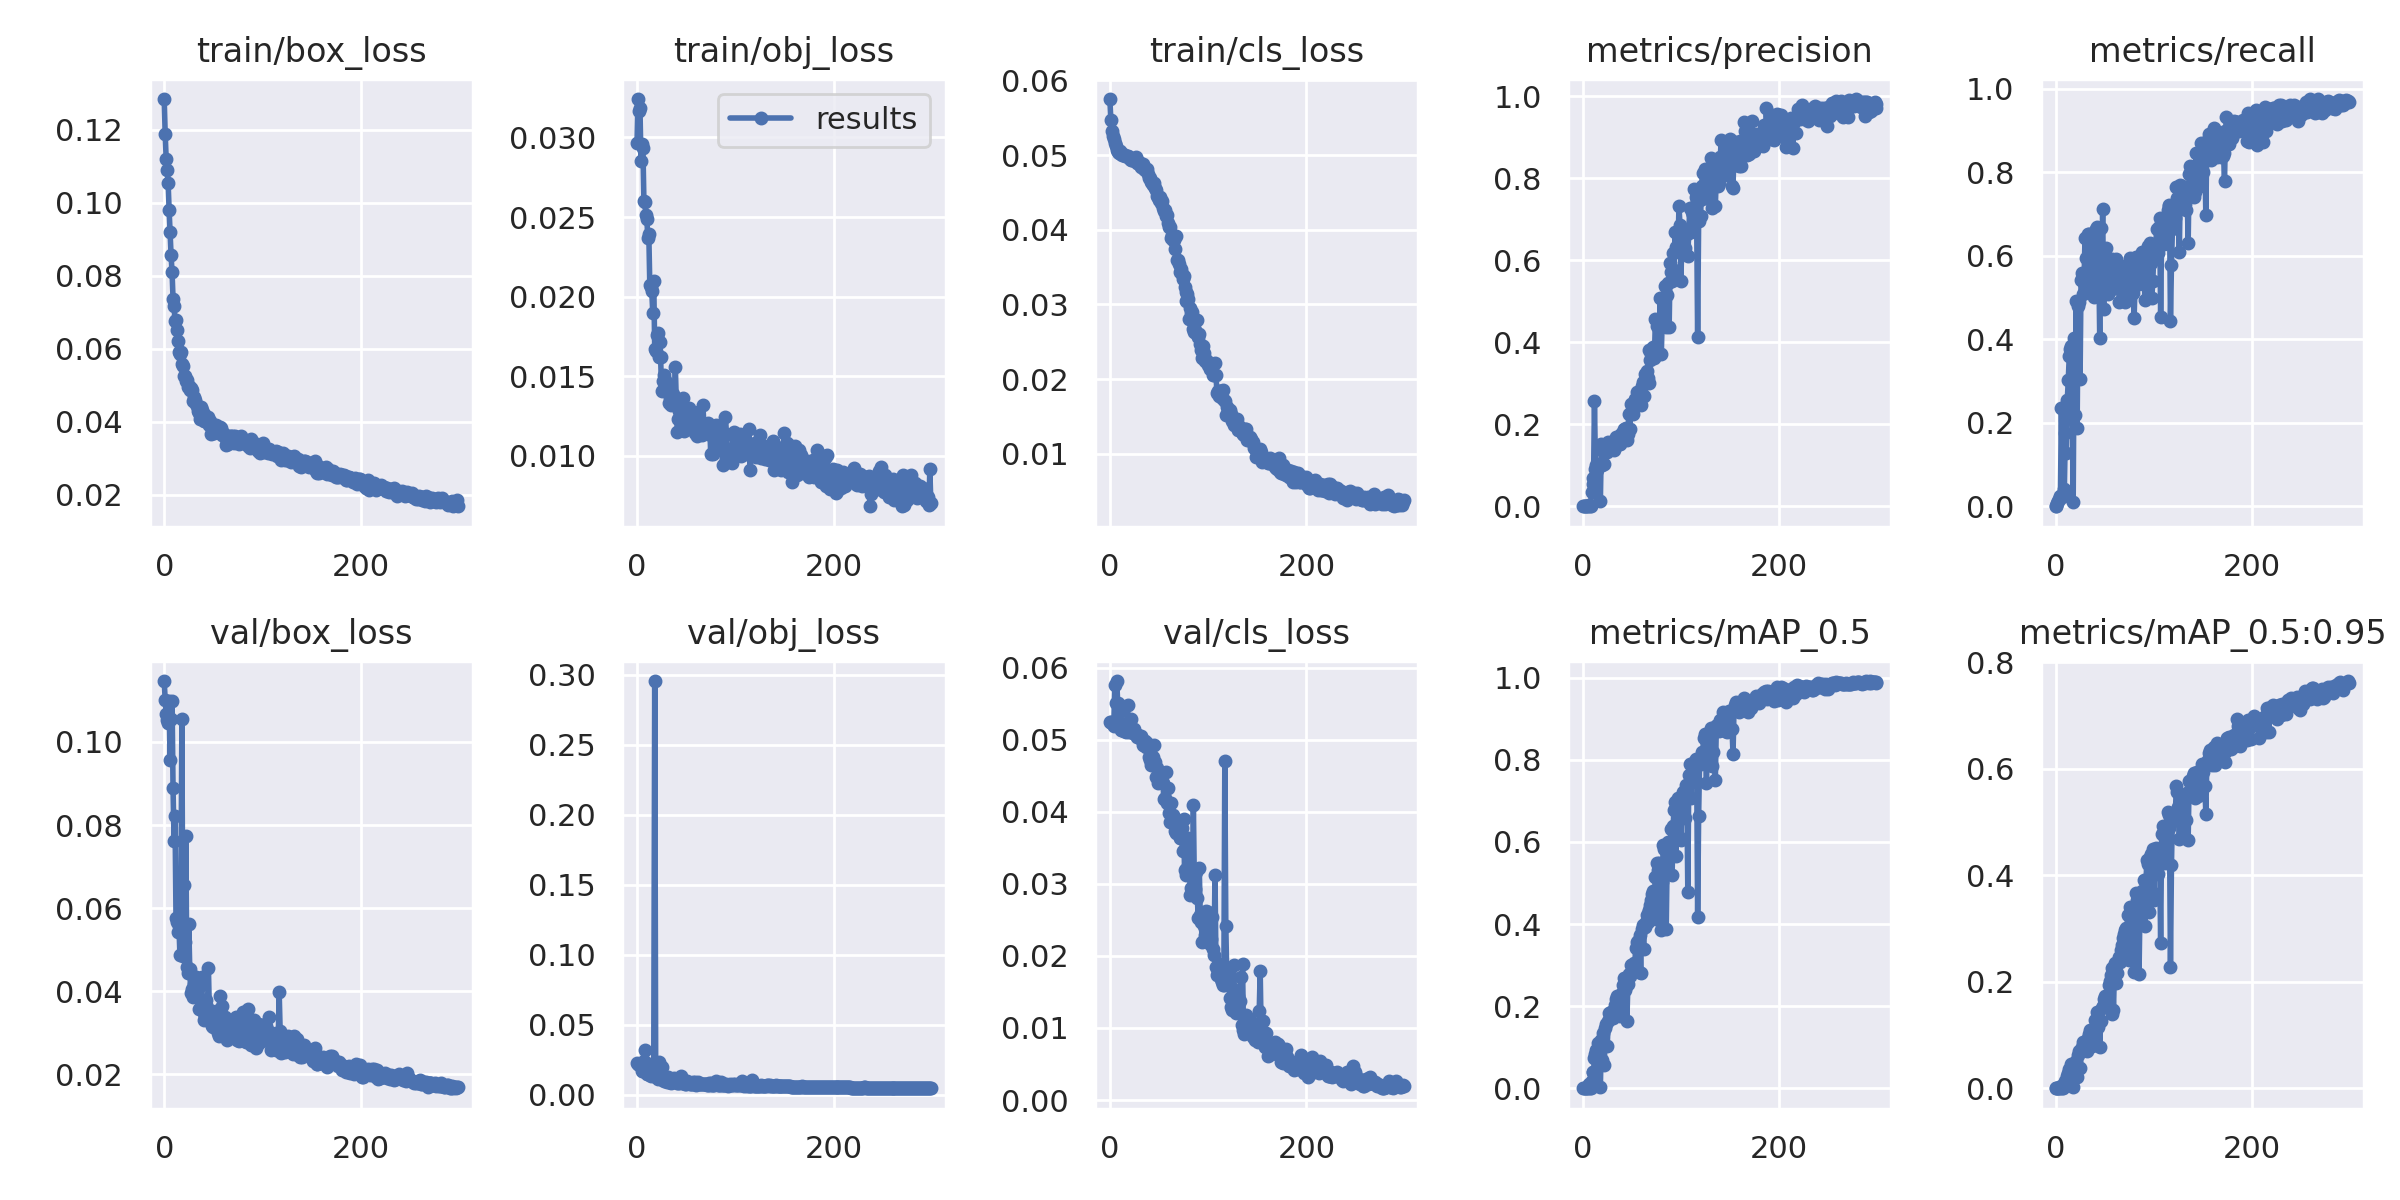

In [ ]:
from IPython.display import Image, clear_output  # to display images
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1200)  # view results.png

Possibly, our model might be a bit overfitted. It seems as if the best number of the epochs for the model is equal about 250~350 epochs. Lets check the visualization of the detection on the validation batch of data.

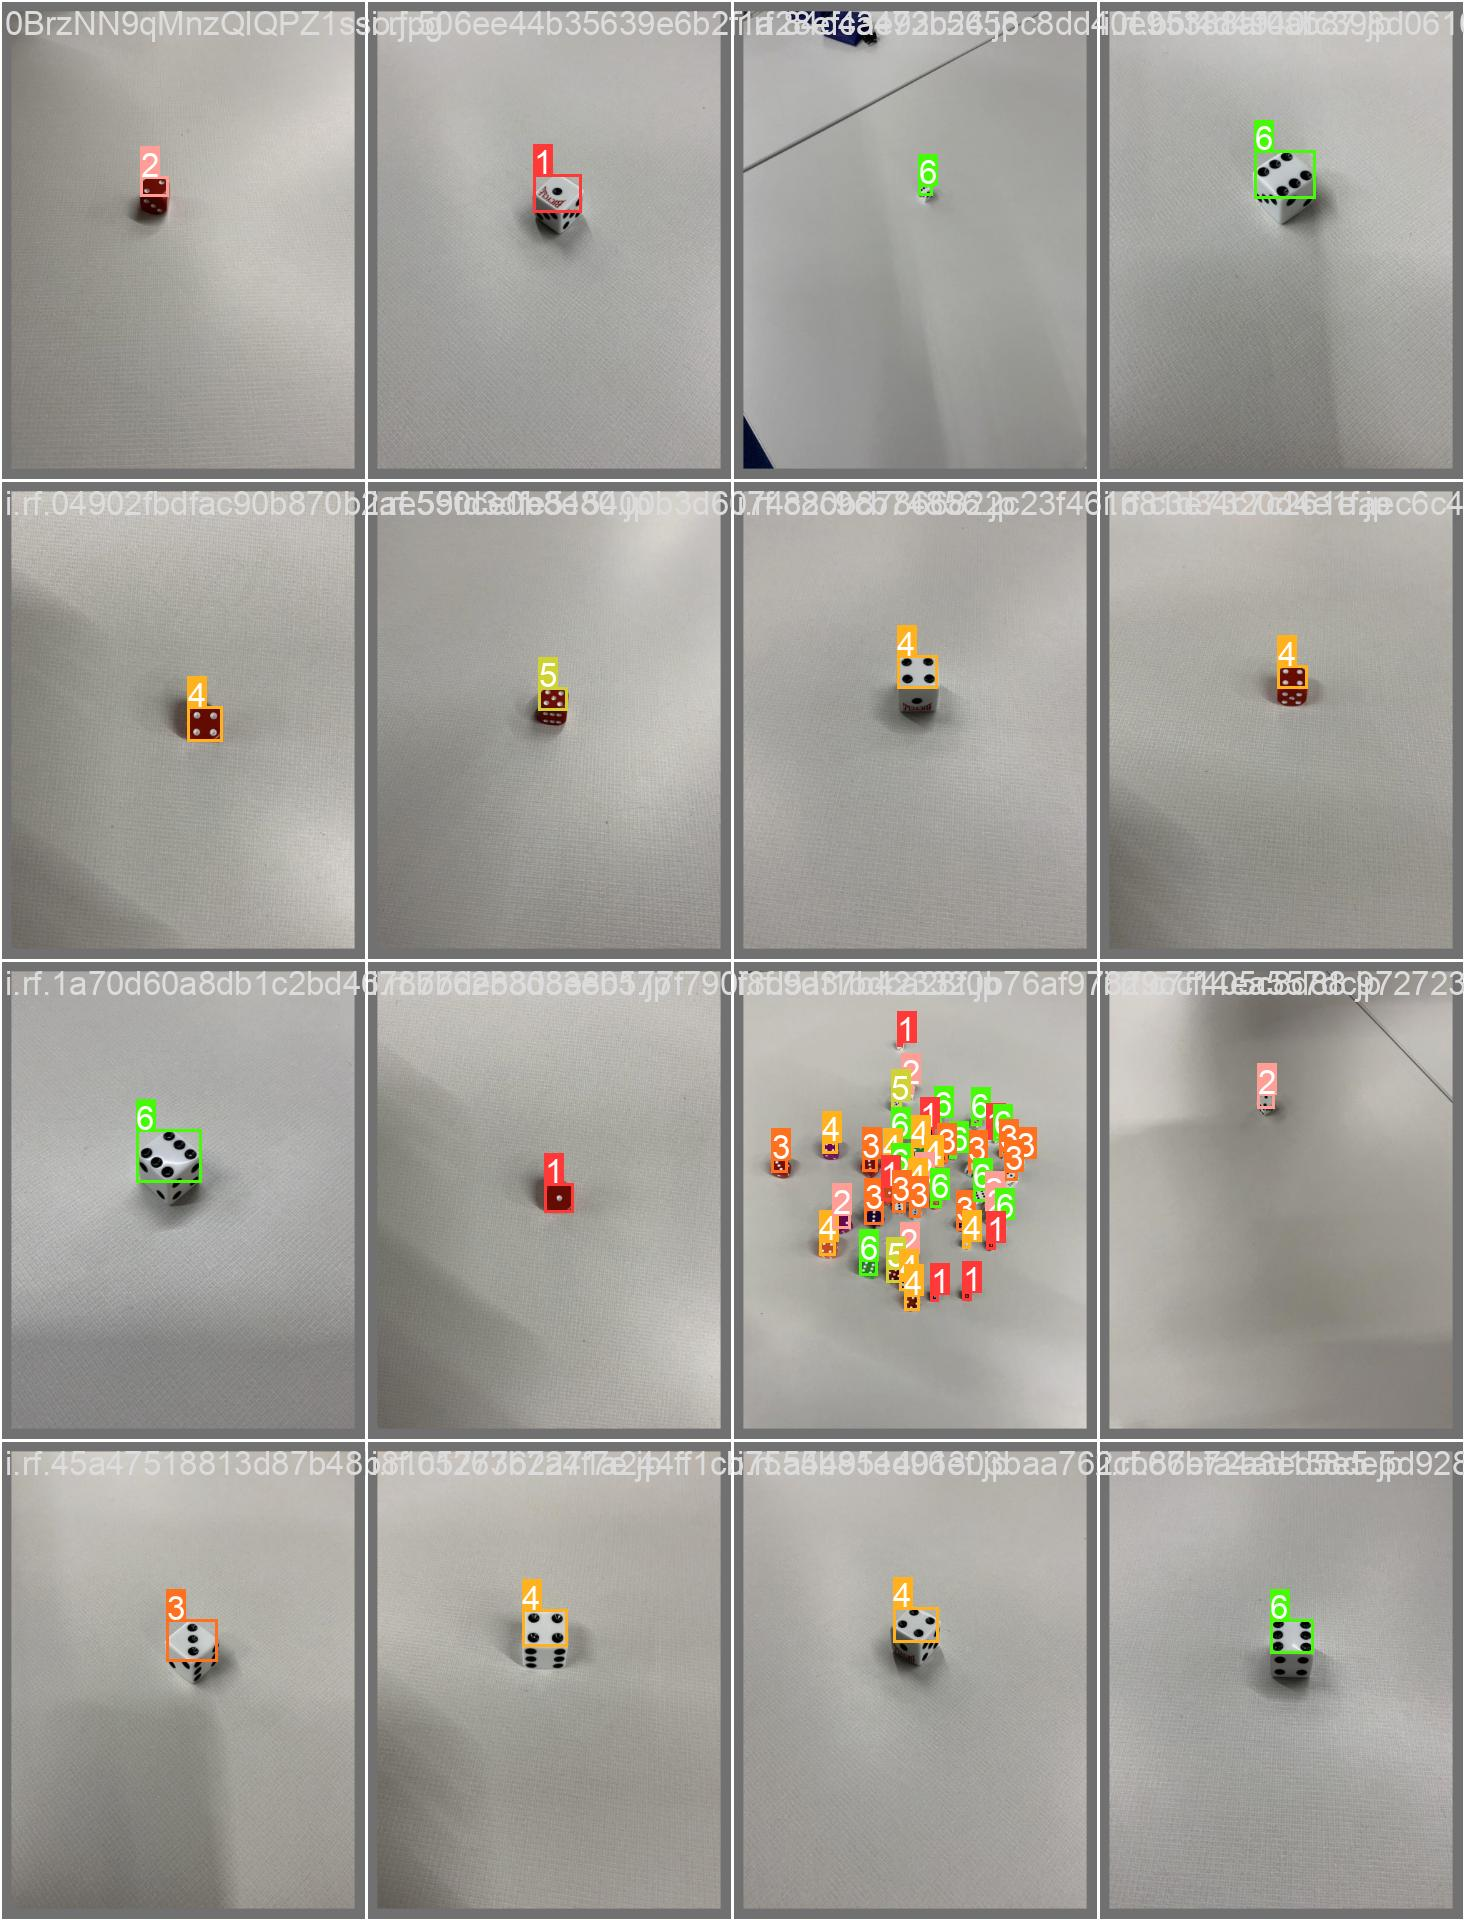

In [ ]:
# Let's have a look at the val batch detection results
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

It doesn't look so bad! Let's have a look at other type of results visualization

**F1-Confidence Curve** shows the dependence of the F1 score of the choosen confidence level



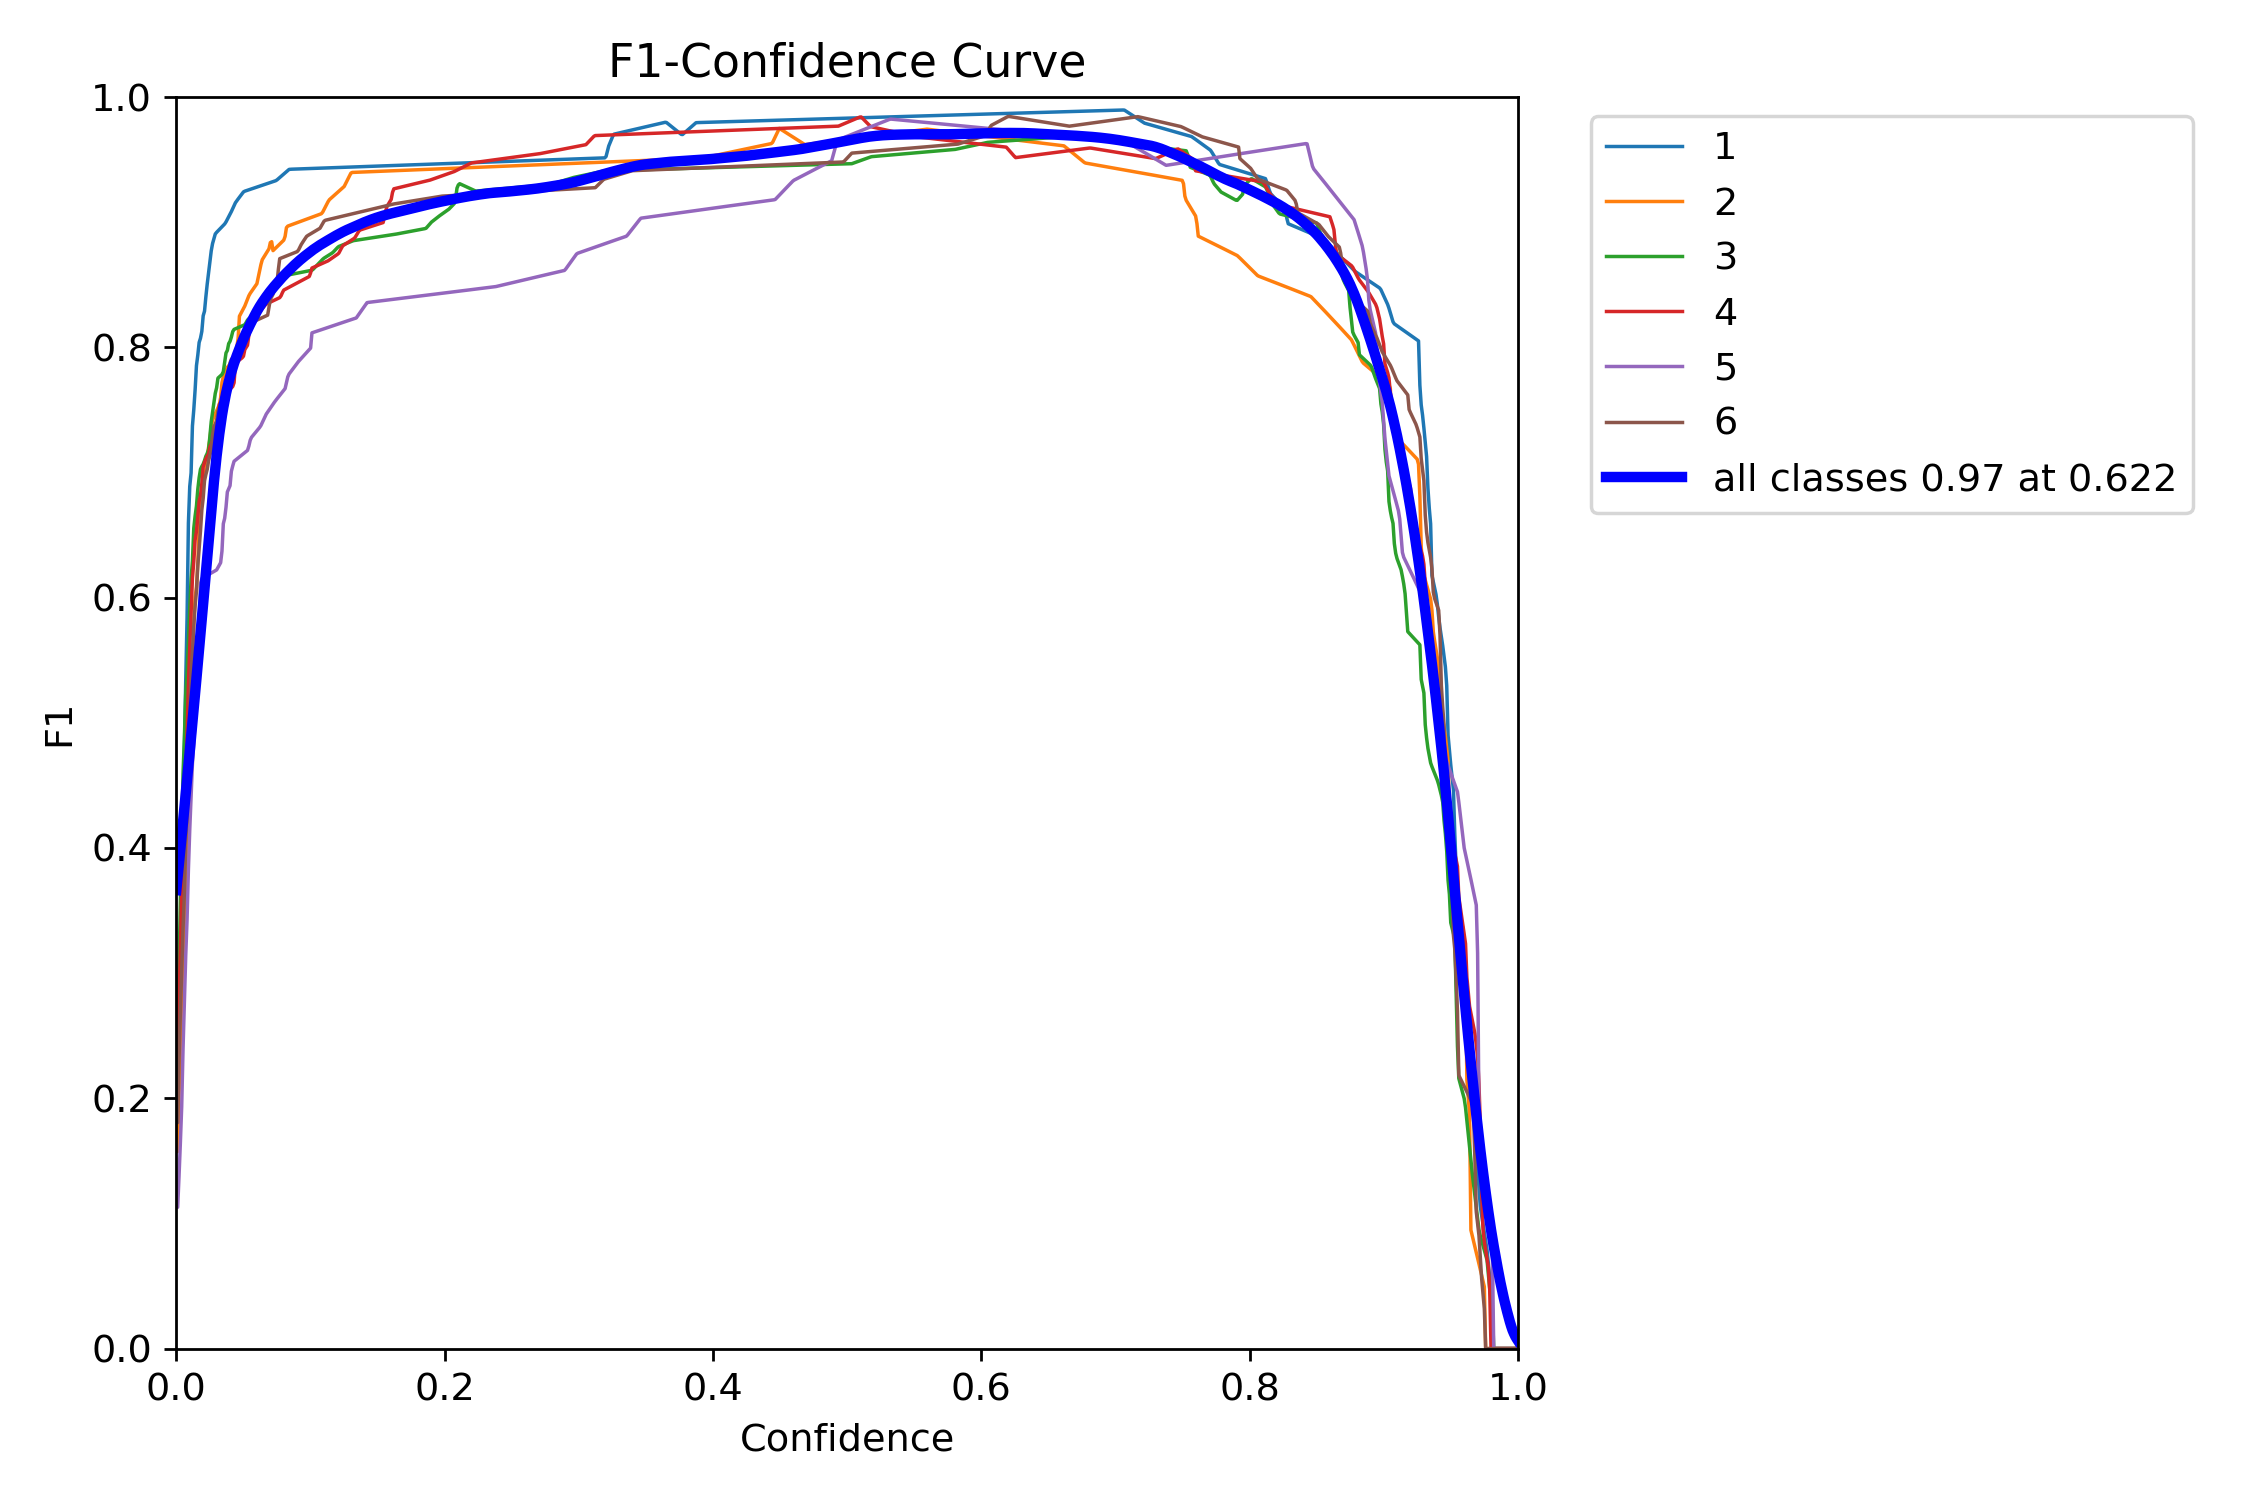

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/F1_curve.png', width=900)

The higher F1 while the confidence level is ~ 0.59

**PR Curve** shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)

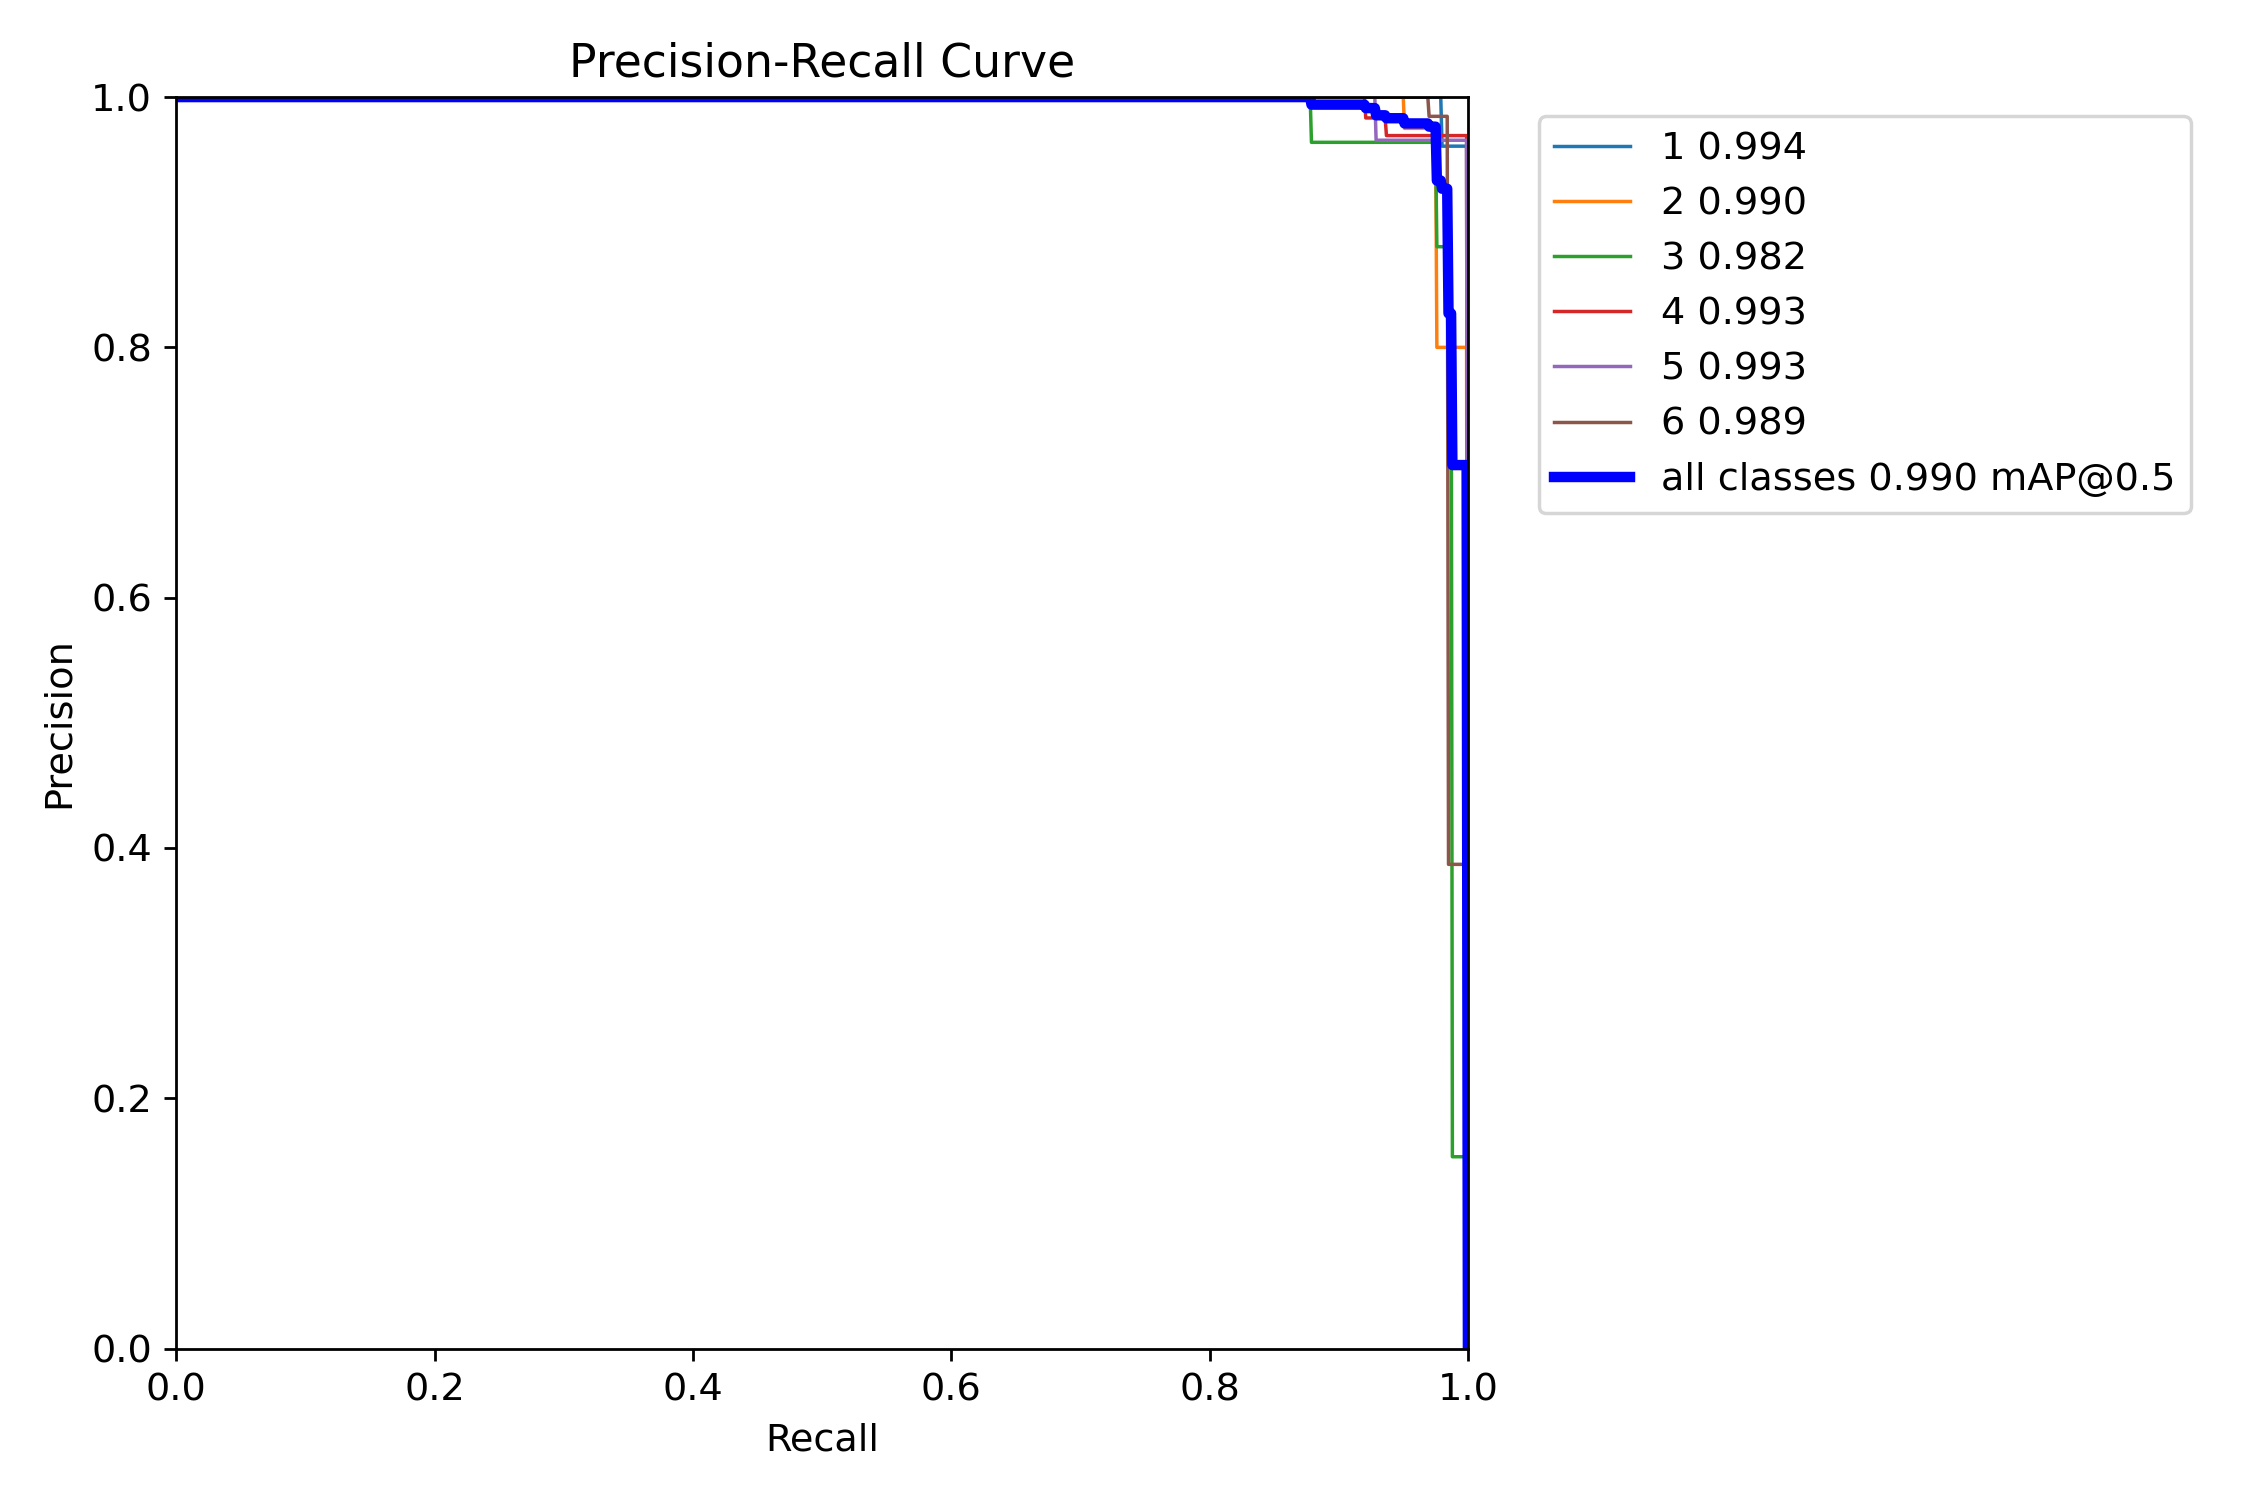

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/PR_curve.png', width=900)

## Custom object detection

I've made some photos myself. Let's check how good the model deals with them. You can find the images in the /datasets/d6dices/validation folder

In [ ]:
%python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.59 --source /content/validation/Images

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/validation/Images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.59, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7260003 parameters, 0 gradients
image 1/14 /content/validation/Images/1OmViZmred0.jpg: 640x512 1 3, 1 5, 2 6s, 71.8ms
image 2/14 /content/validation/Images/4ST4MPAnexM.jpg: 640x512 1 1, 1 3, 1 4, 1 5, 1 6, 9.5ms
image 3/14 /content/validation/Images/5HmiiZrF2nc.jpg: 640x512 1 1, 1 2, 1 3, 1 4, 1 6, 12.5ms
image 4/14 /content/validation/Images/5aHytQ990Wc.jpg: 64

Let's have a look at some of our images

In [ ]:
VAL_IMG_PATH = pathlib.Path('/content/yolov5/runs/detect/exp/')

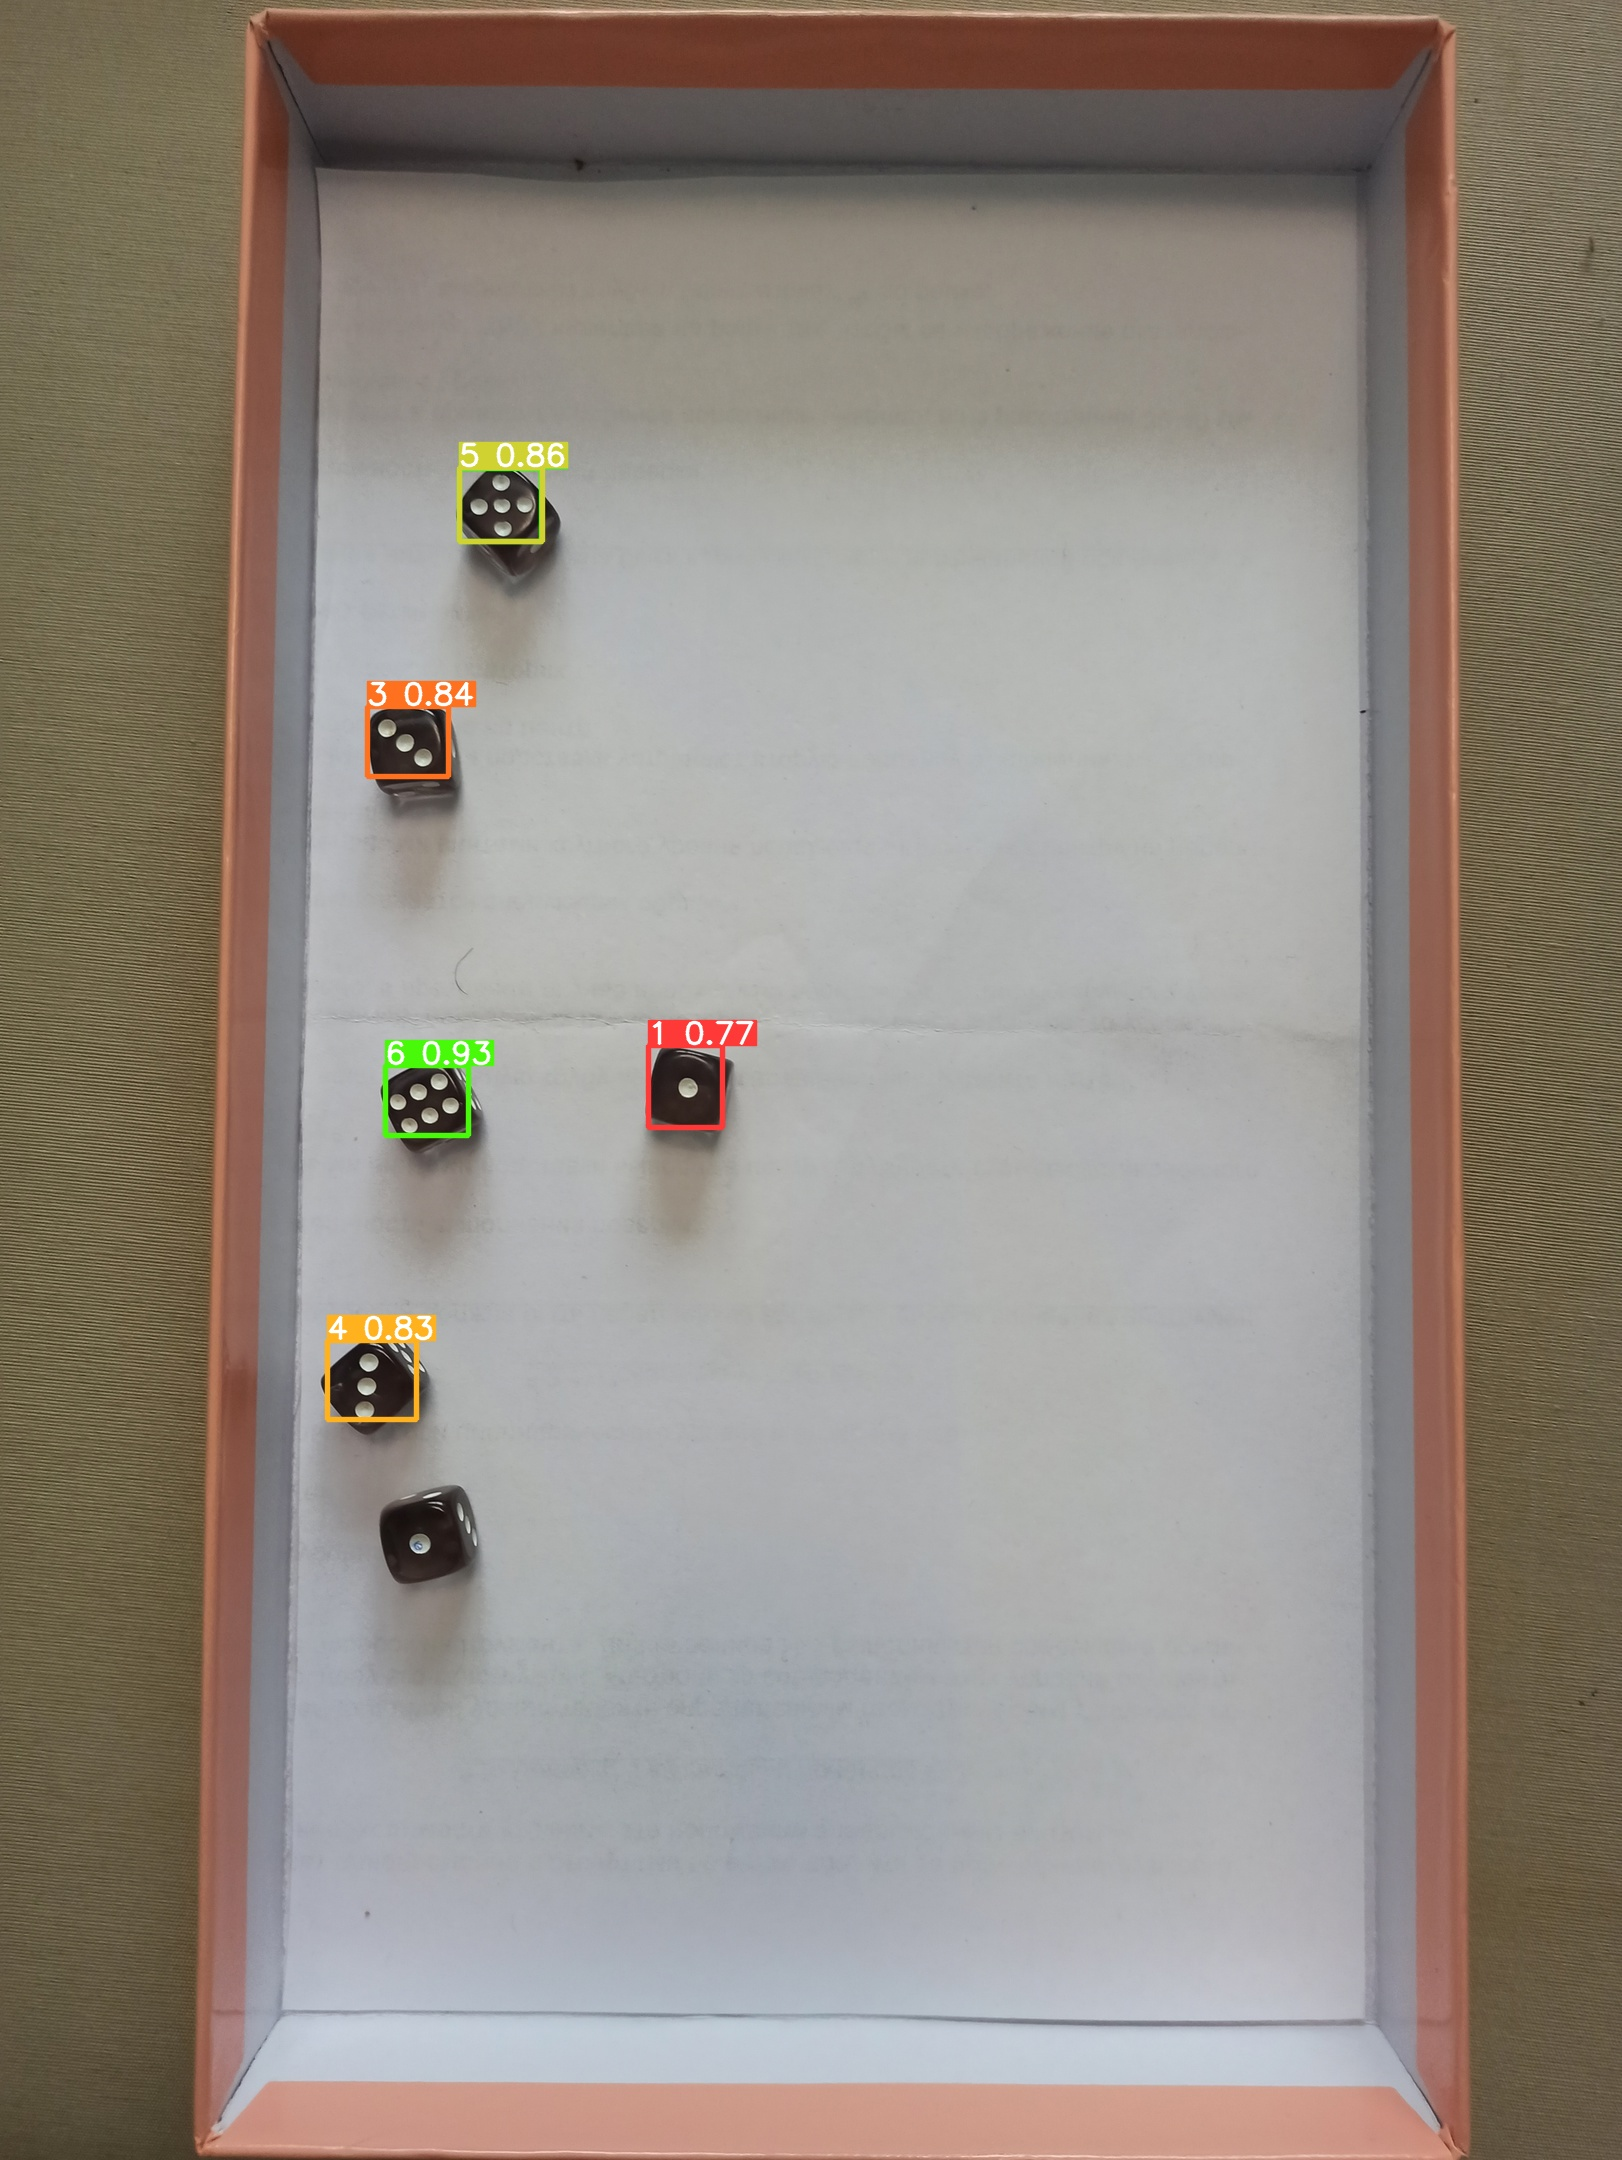

In [ ]:
Image(filename=random.sample(list(VAL_IMG_PATH.glob('*.jpg')), k=1)[0], width=900)

Well... Not so good... You can try other images. I do not satisfy with the results, let's try the other YOLO model instead.

# YOLOV8 Experiment

In [ ]:
#Back to the root dir
%cd ..
os.getcwd()

/content


'/content'

In [ ]:
%pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/data.yaml epochs=50 imgsz=800 plots=True

100% 21.5M/21.5M [00:00<00:00, 70.7MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/data.yaml, epochs=50, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False,

## Training results visualization

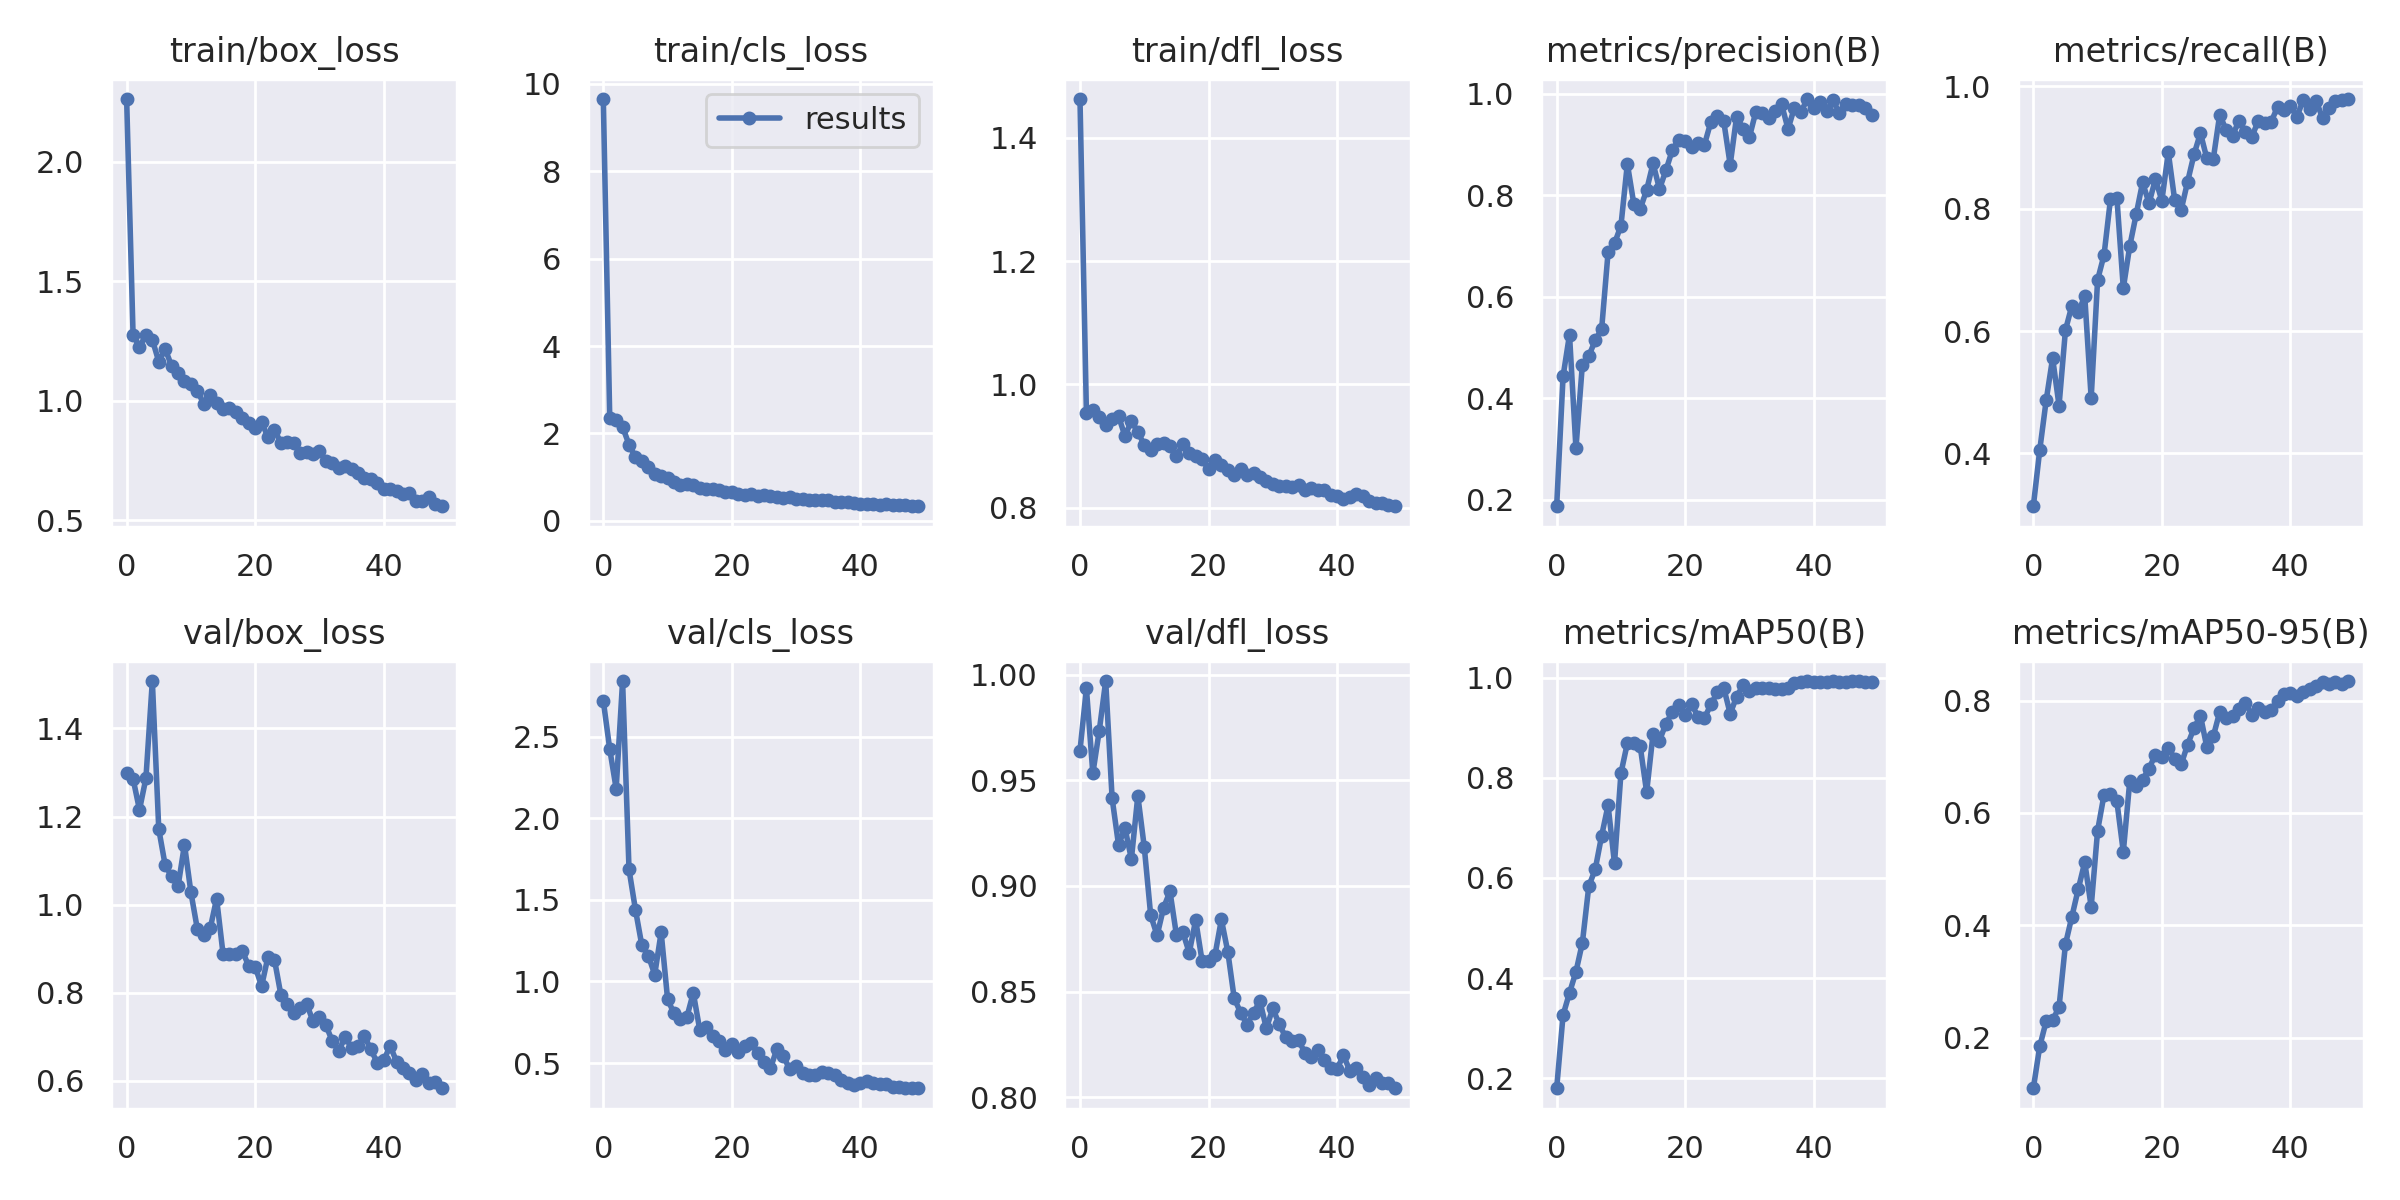

In [ ]:
Image('/content/runs/detect/train/results.png', width=900)

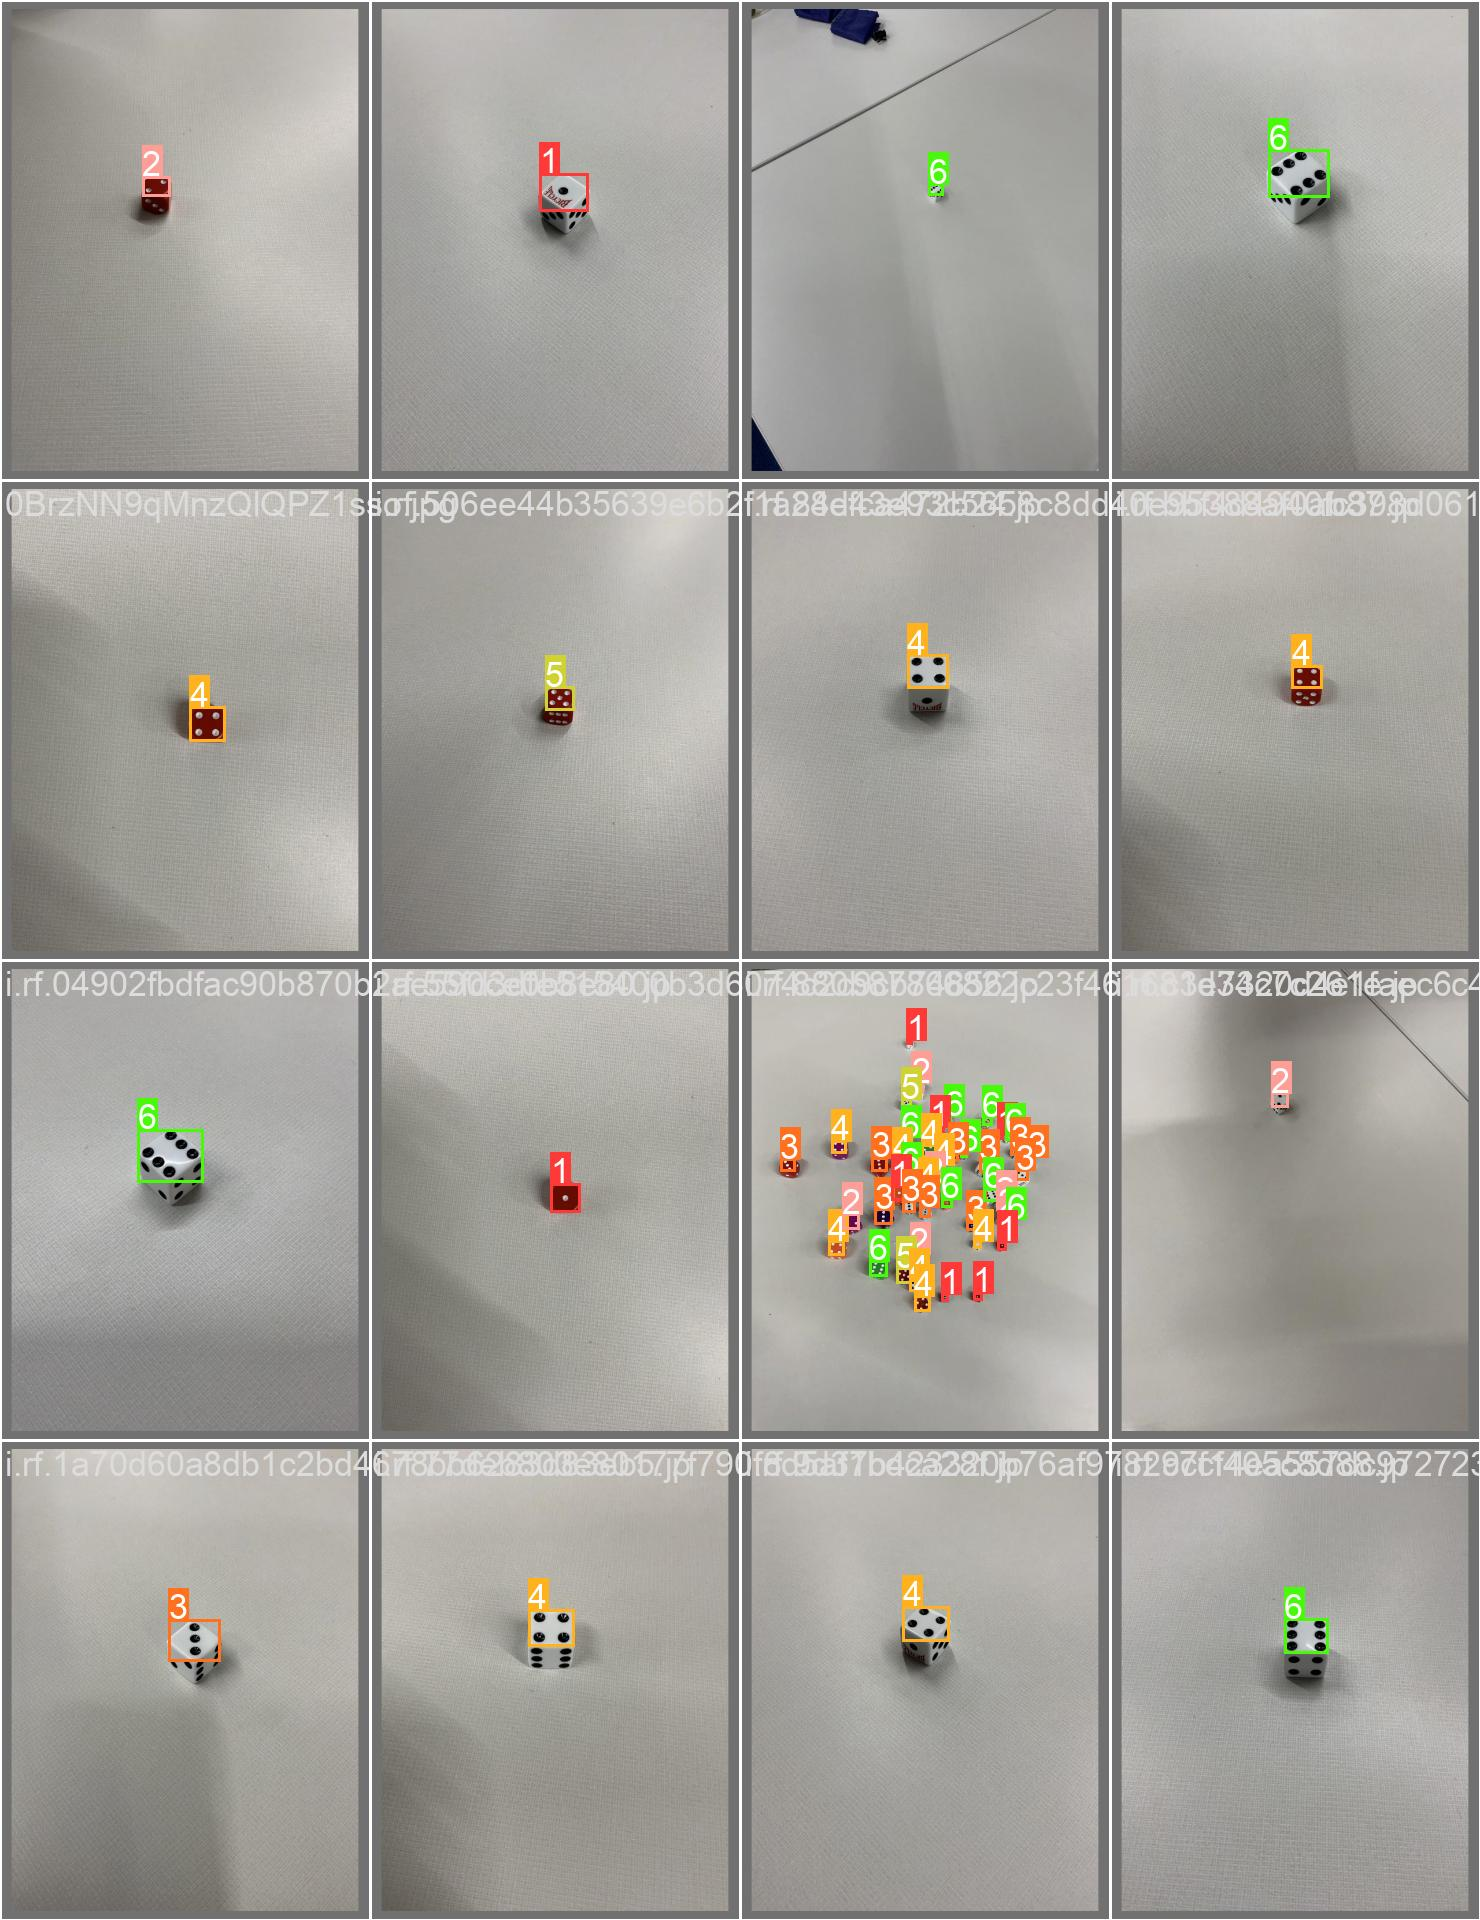

In [ ]:
Image('/content/runs/detect/train/val_batch0_labels.jpg', width=900)

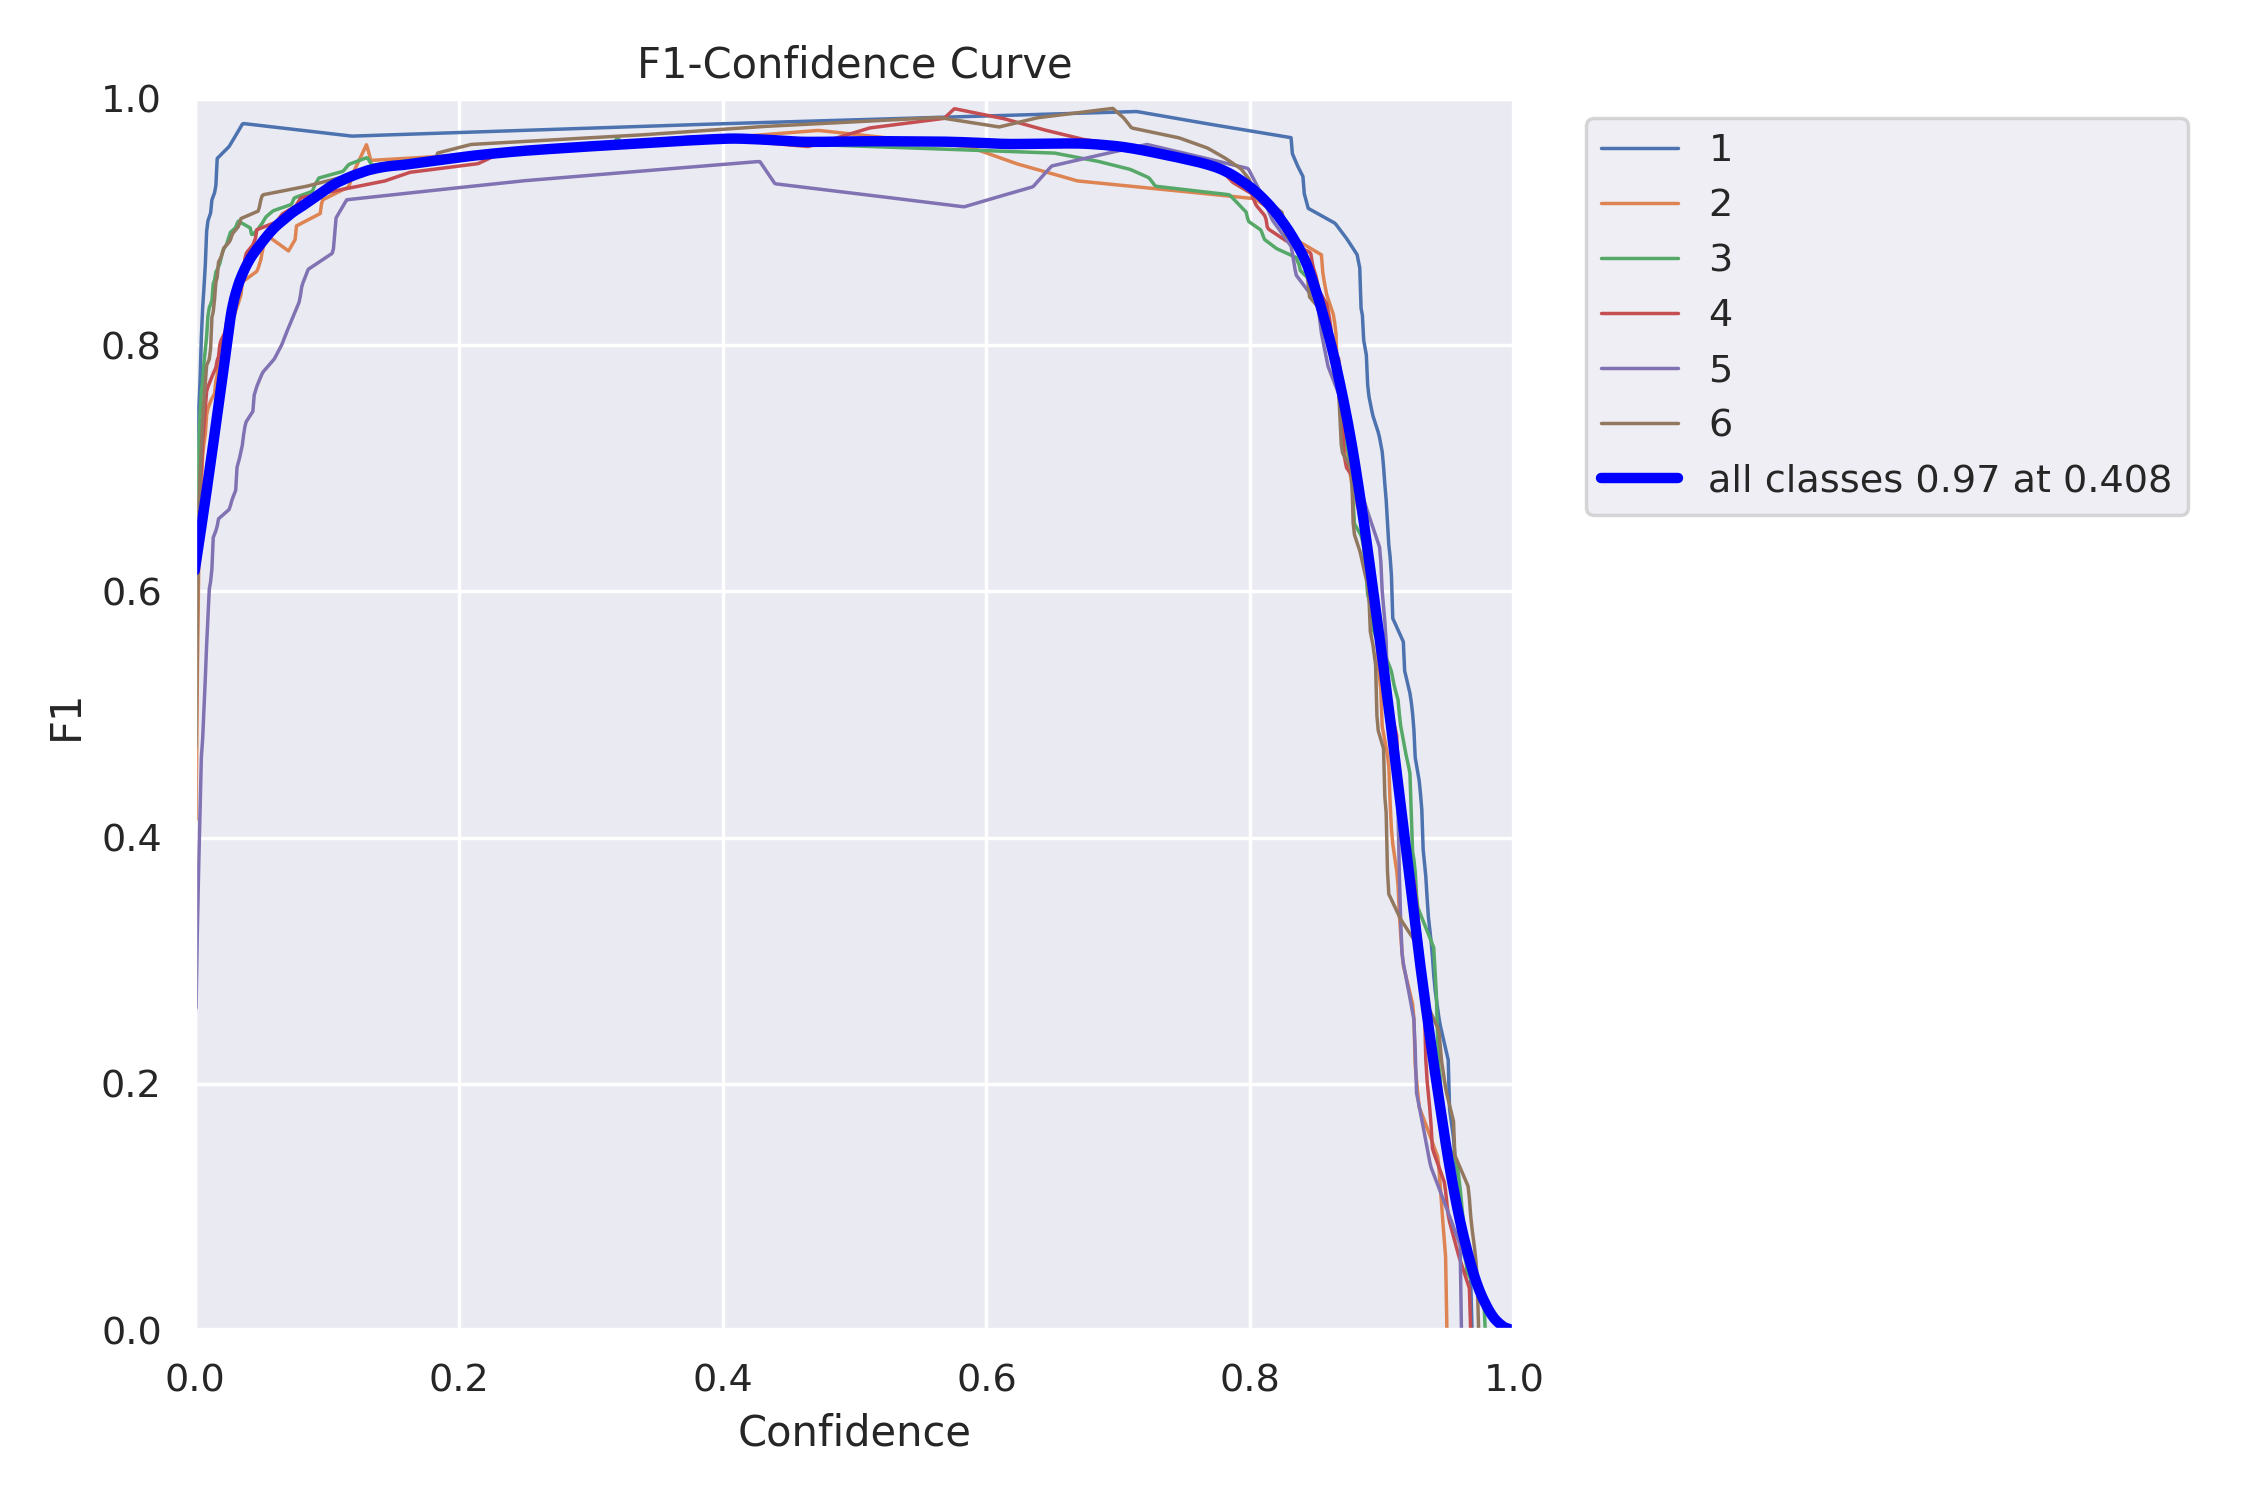

In [ ]:
Image('/content/runs/detect/train/F1_curve.png', width=900)

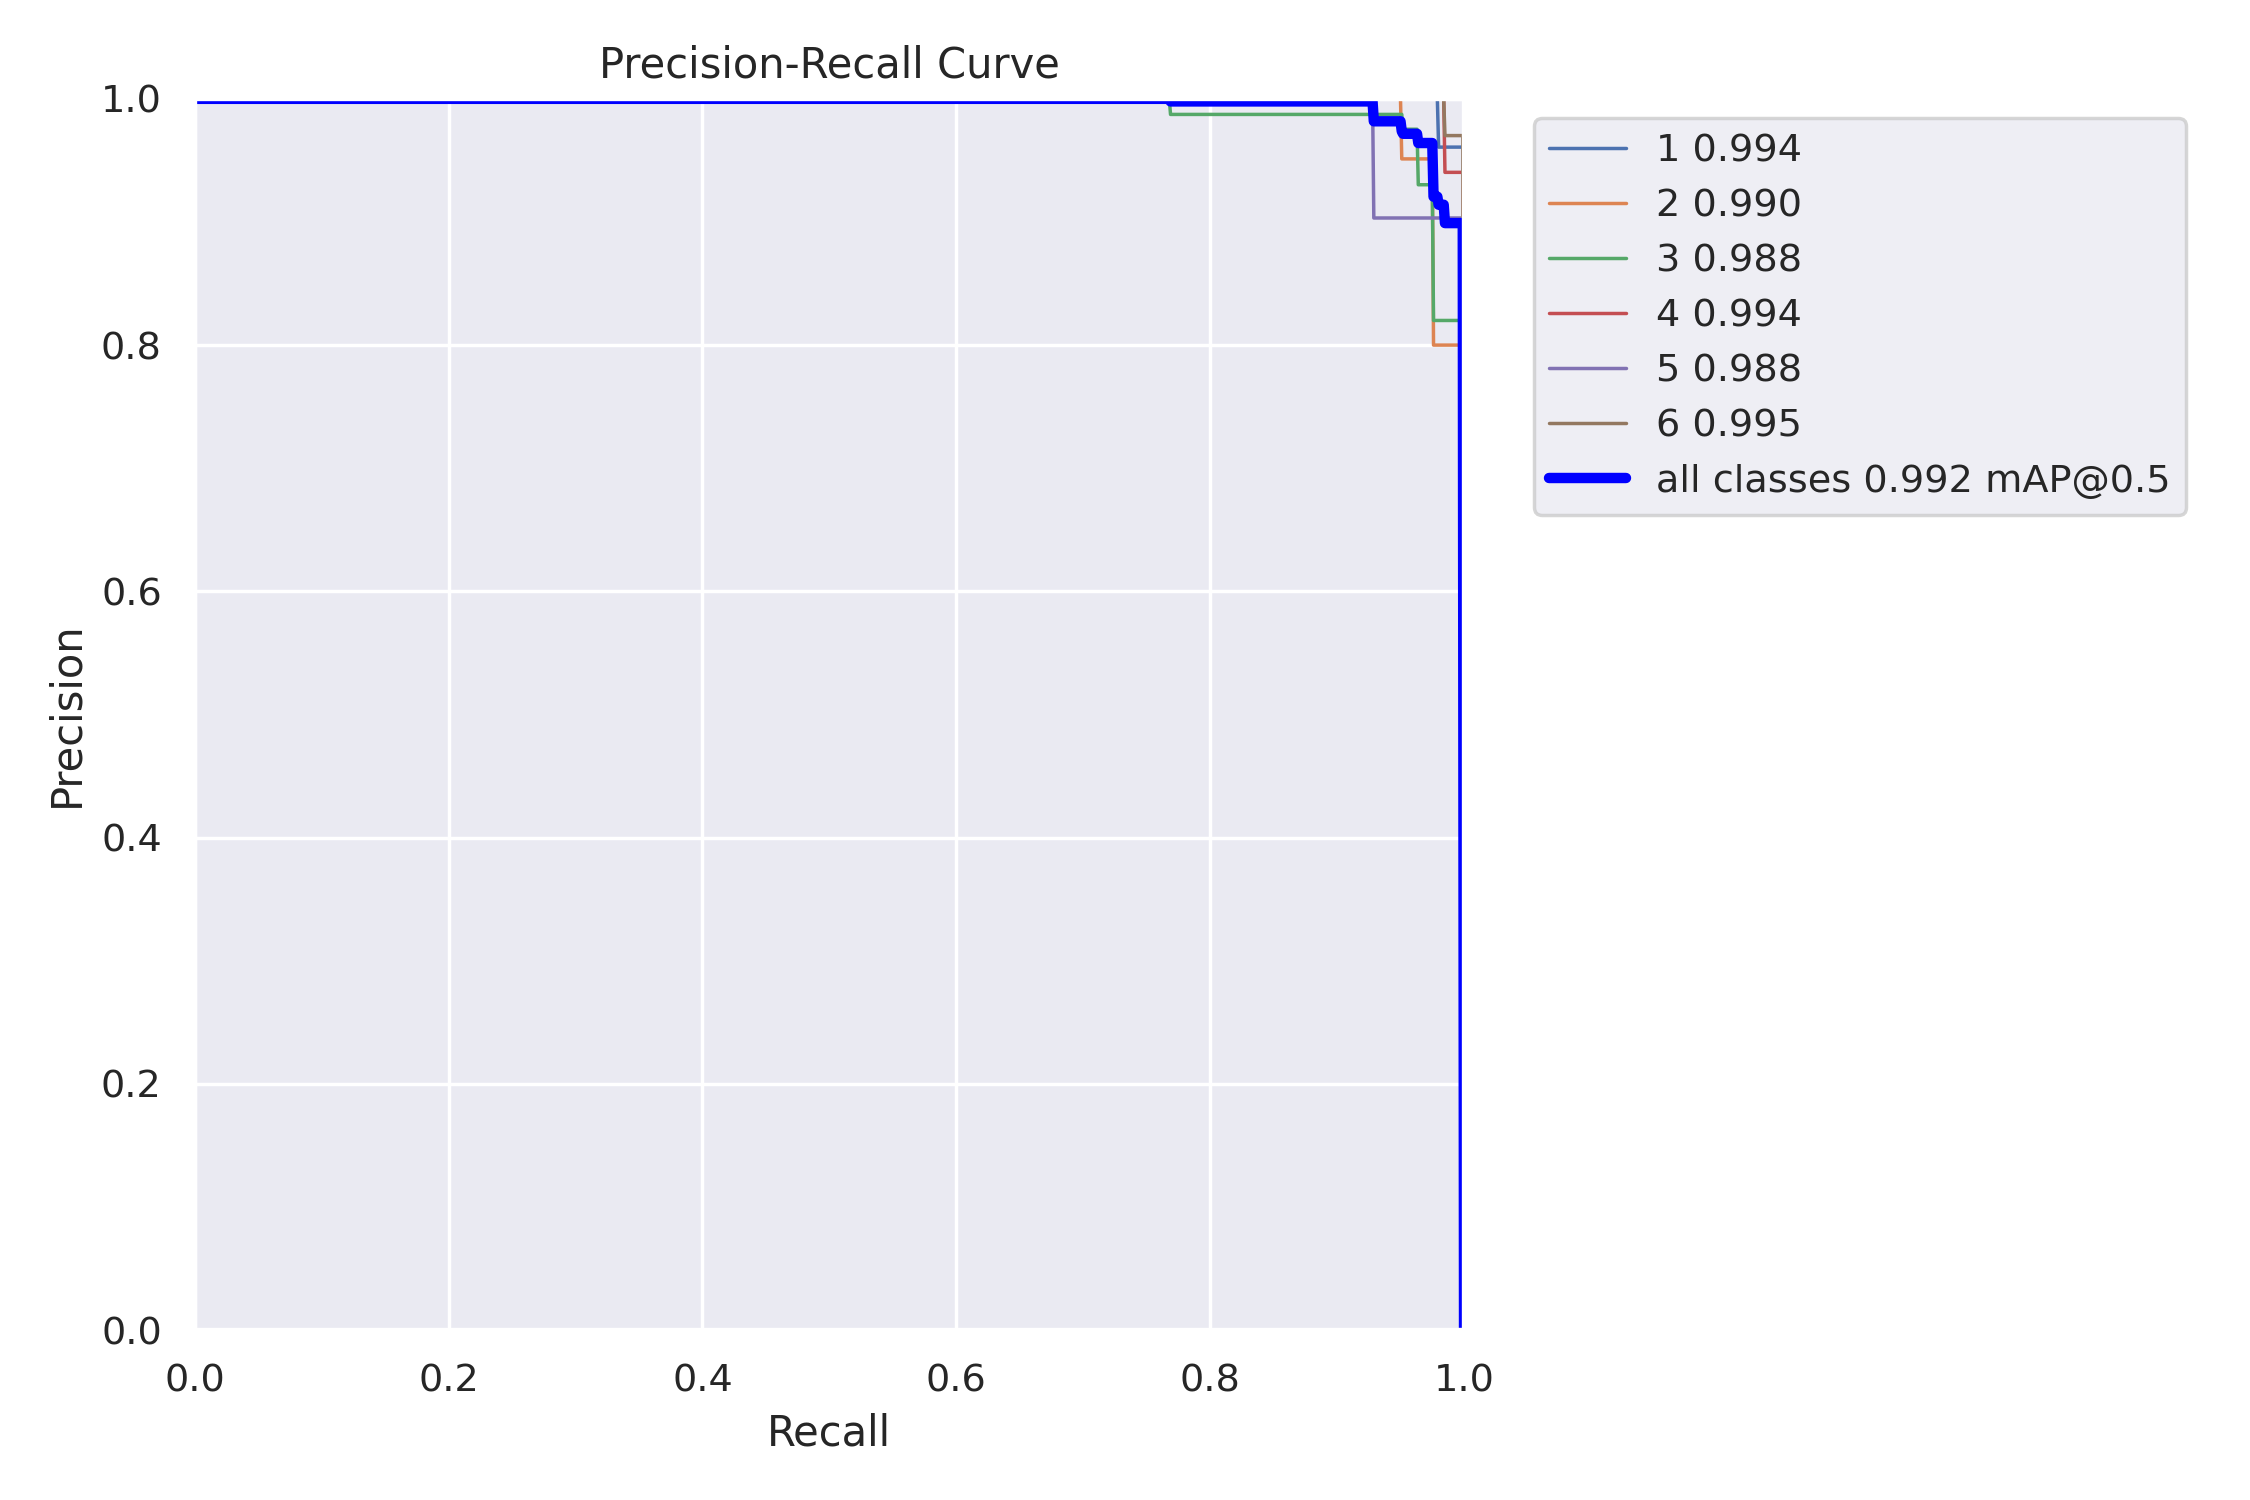

In [ ]:
Image('/content/runs/detect/train/PR_curve.png', width=900)

Not bad for only 25 epochs. Let's try predict classes for images that not in the dataset

In [ ]:
%yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.408 source=/content/validation/Images save=True

2023-09-10 07:58:03.951373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 07:58:05.052333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs
image 1/14 /content/validation/Images/1OmViZmred0.jpg: 800x608 1 2, 2 3s, 2 5s, 74.7ms
image 2/14 /content/validation/Images/4ST4MPAnexM.jpg: 800x608 2 3s, 2 4s, 1 5, 2 6s, 19.5ms
image 3/14 /content/validation/Images/5HmiiZrF2nc.jpg: 800x608 2 1s, 1 2, 1 4, 1 5, 19.5ms
image 4/14 /content/validation/Images/5aHytQ990Wc.jpg: 800x608 1 1, 2 3s, 2 5s, 19.5ms
image 5/14 /content/validation/Images/

In [ ]:
VAL_IMG_PATH_YOLO8 = pathlib.Path('/content/runs/detect/predict')

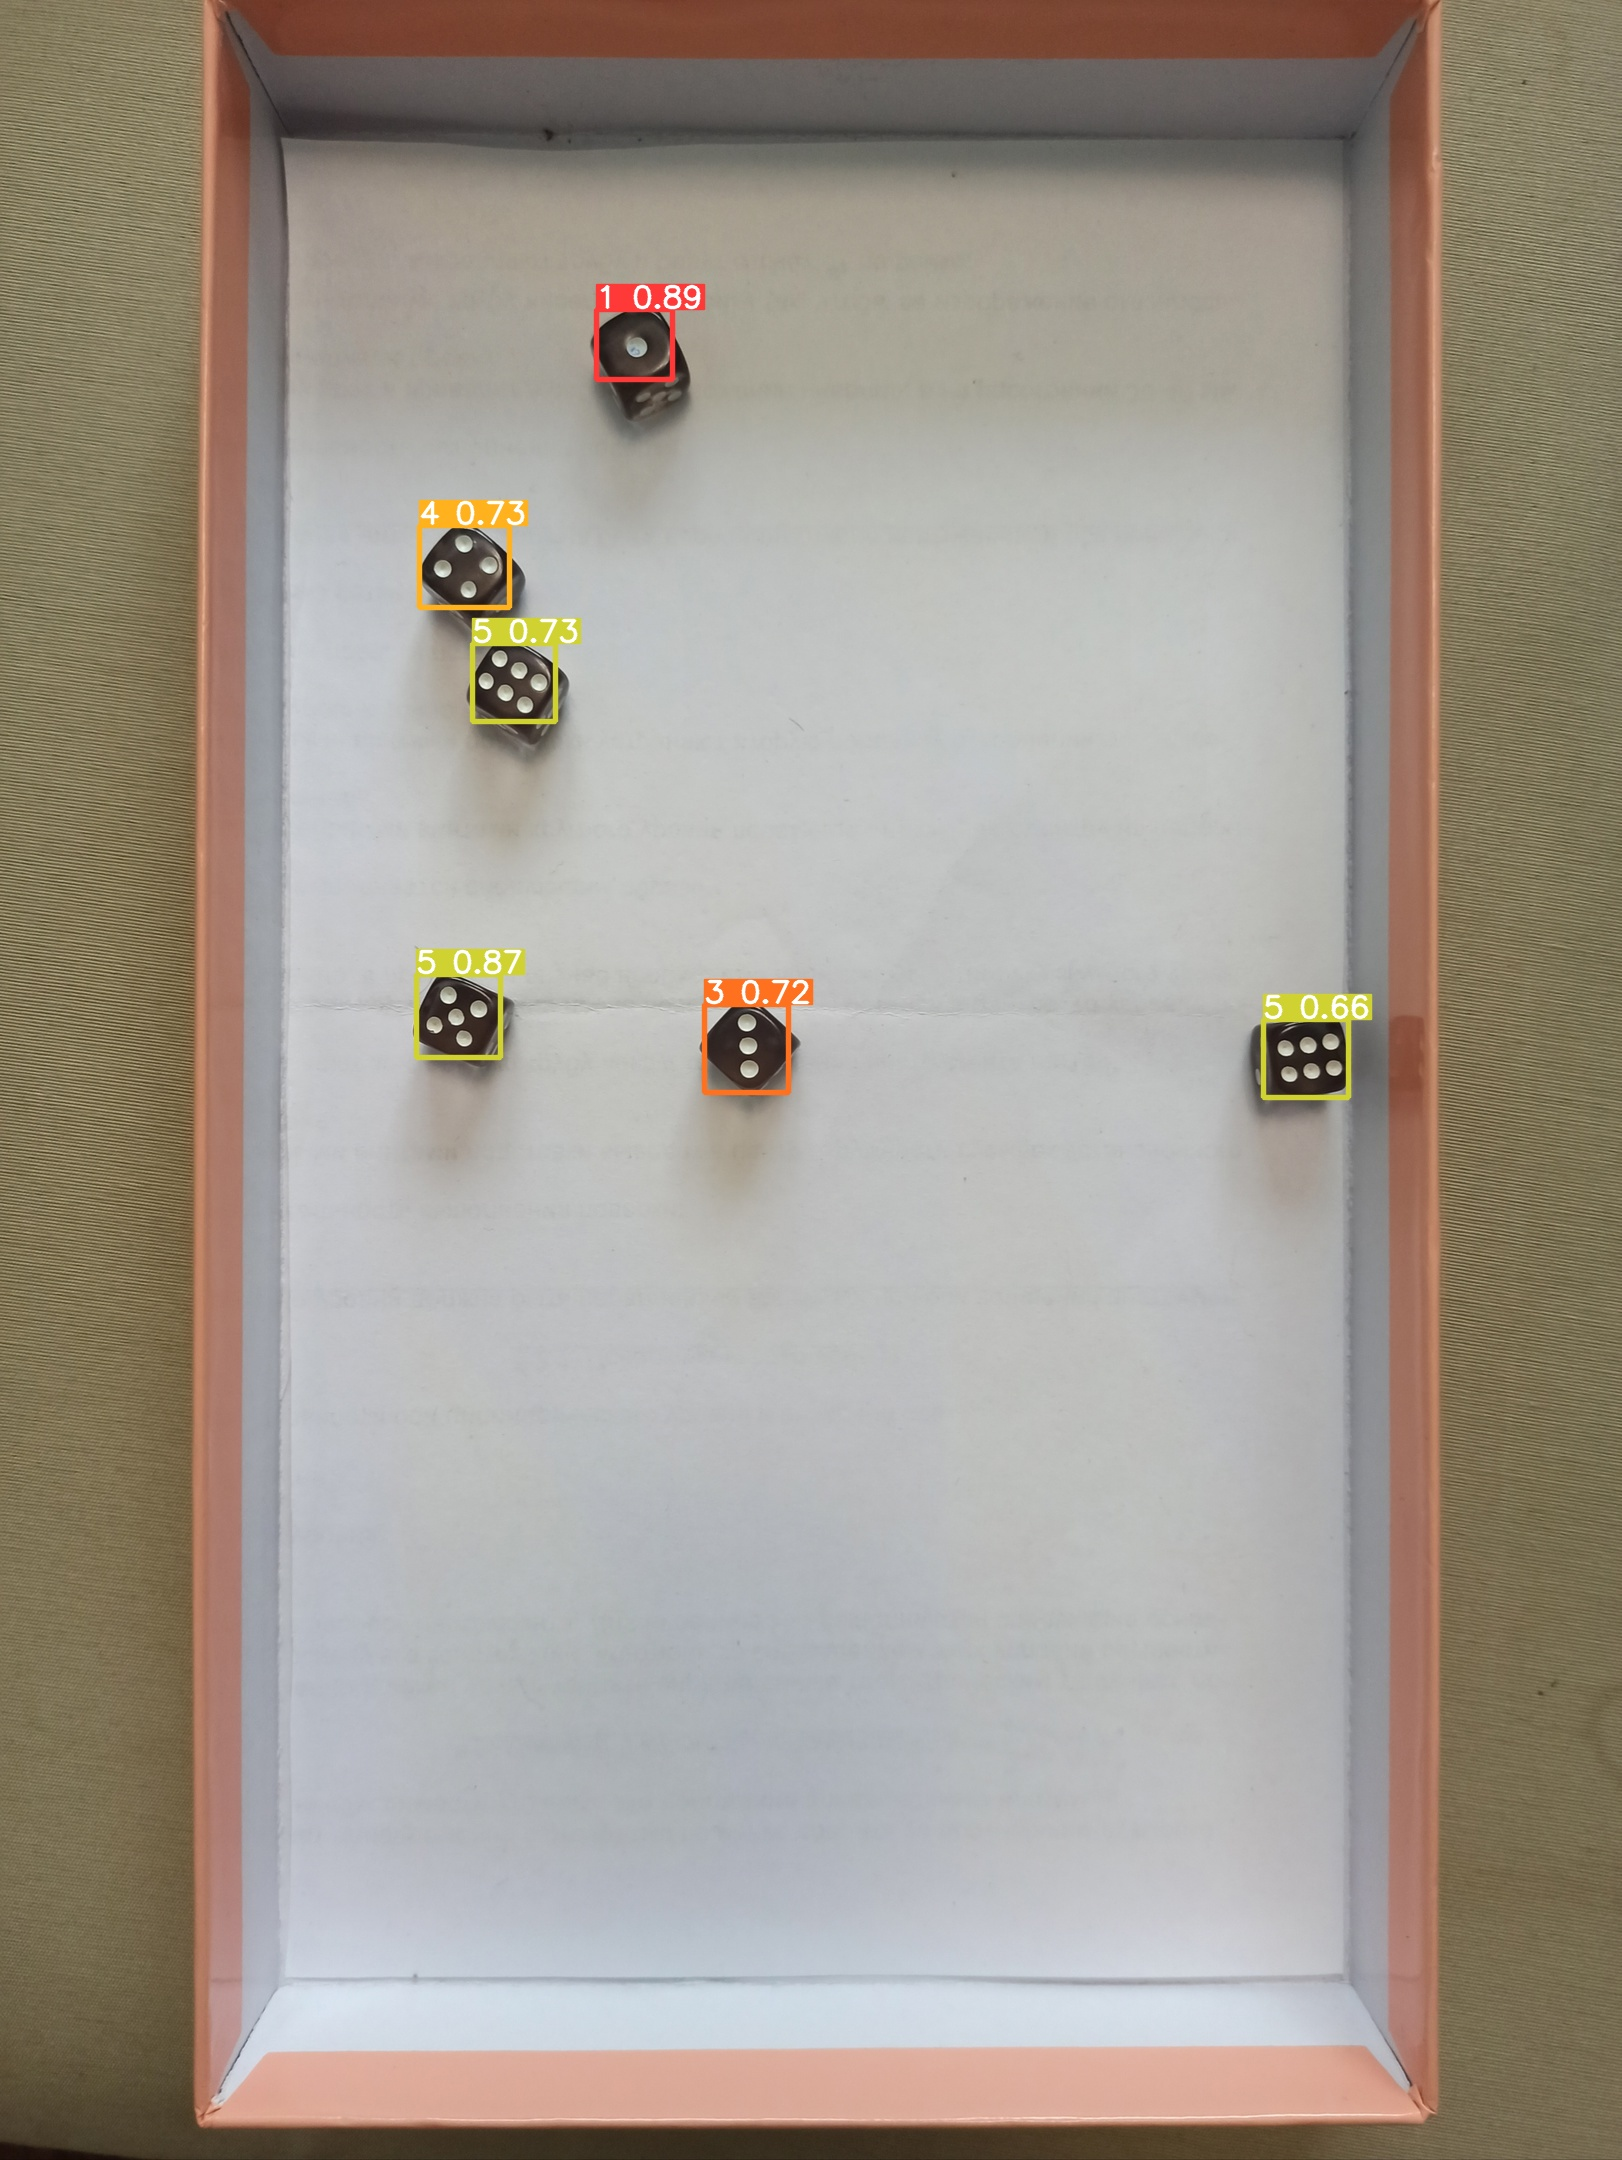

In [ ]:
Image(filename=random.sample(list(VAL_IMG_PATH_YOLO8.glob('*.jpg')), k=1)[0], width=900)

Way more better! It's not ideal yet, but the performance has improved, as far as I can see. It'd be a nice idea to compare results of both models

# YoloV5 vs YoloV8 results comparison

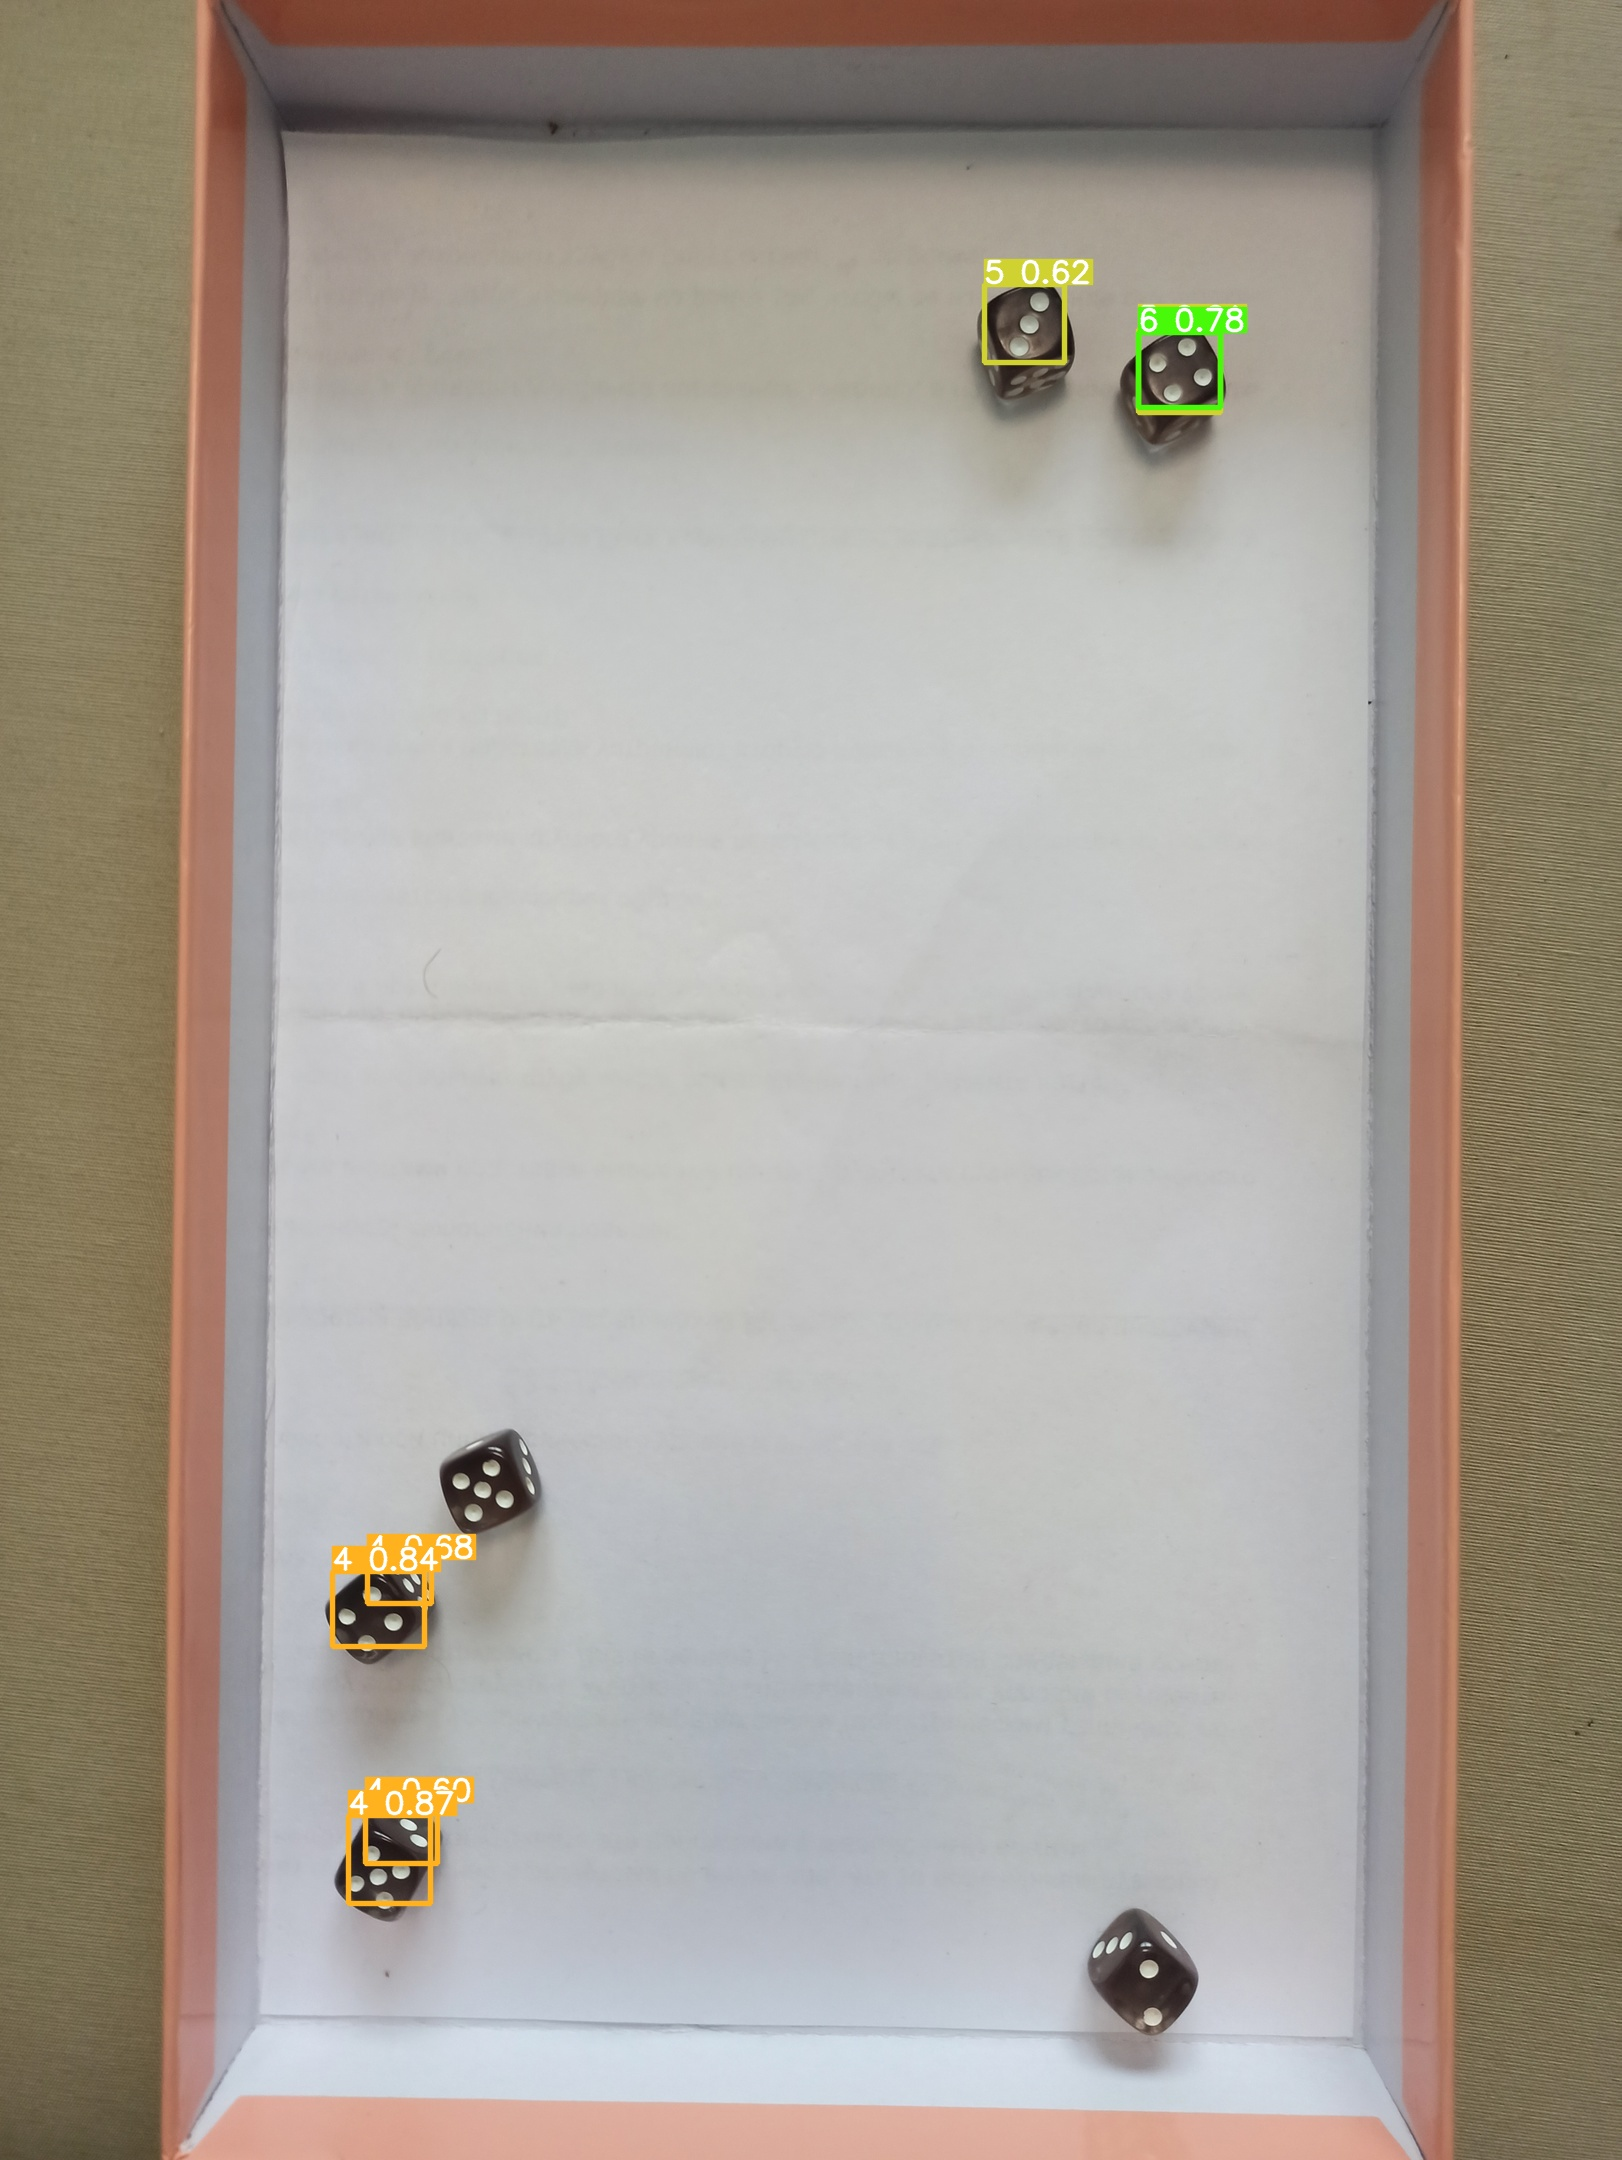

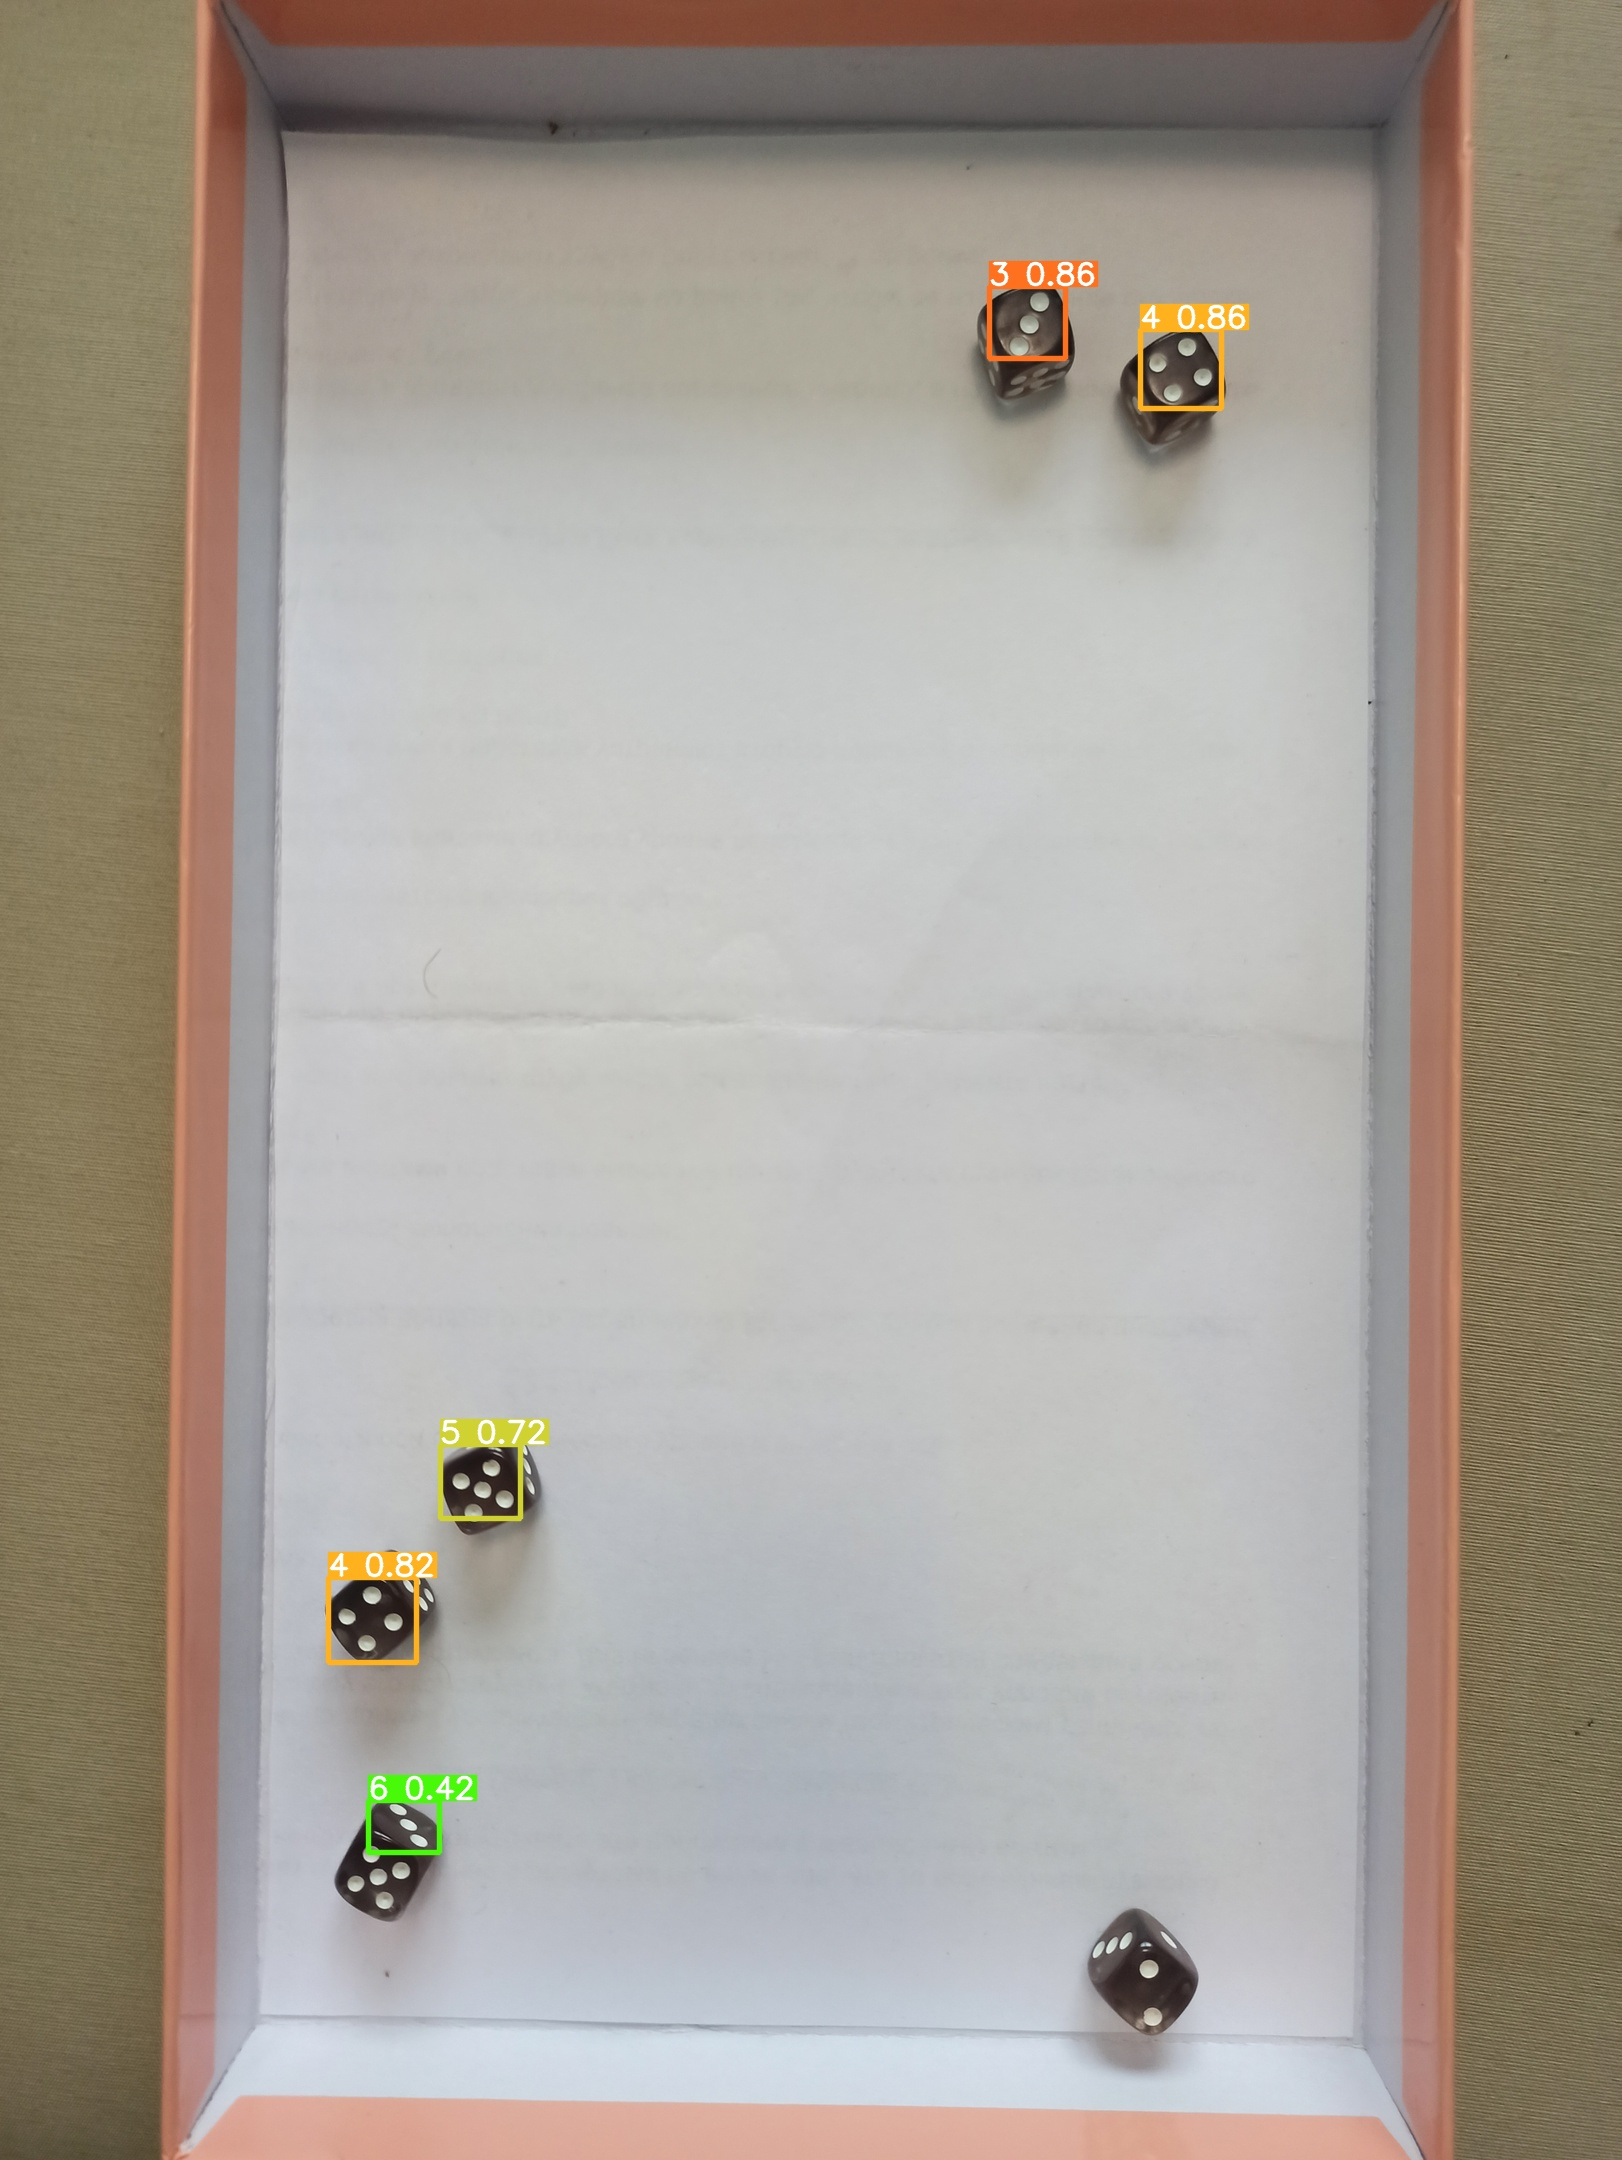

In [ ]:
from IPython.display import display

YOLO5_PATH = VAL_IMG_PATH
YOLO8_PATH = VAL_IMG_PATH_YOLO8

random_img_name = random.sample(list(VAL_IMG_PATH_YOLO8.glob('*.jpg')), k=1)[0].stem + '.jpg'

img1 = Image(YOLO5_PATH / random_img_name, width=450)
img2 = Image(YOLO8_PATH / random_img_name, width=450)

display(img1, img2)

Even though the model performance is far away from the perfection it seems like the good result may be achieved! Posiibly, the larger number of epochs for the YOLOV8 model may improve the result.   

# Let's compare results on the video

You can find video files in the project folder videos\D6_with_dots

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt source=/content/validation/Videos/D6_with_dots imgsz=1280 save=True conf=0.4

2023-09-10 08:00:02.349887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 08:00:03.585725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs
video 1/1 (1/103) /content/validation/Videos/VID_20230909_173129.mp4: 1280x736 59.7ms
video 1/1 (2/103) /content/validation/Videos/VID_20230909_173129.mp4: 1280x736 29.2ms
video 1/1 (3/103) /content/validation/Videos/VID_20230909_173129.mp4: 1280x736 29.2ms
video 1/1 (4/103) /content/validation/Videos/VID_20230909_173129.mp4: 1280x736 29.2ms
video 1/1 (5/103) /content/validation/Videos/VID_202